# Descriptive fit analysis

Last access (y.m.d): 21.05.10  
Last update (y.m.d): 21.05.10   

In this notebook, I gather all V1 [or LGN] cells (data, model, descriptive fits) and analyze based on this complete set.

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures **(0)**
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Simple vs complex **(1)**
- Tuning shifts **(2)**
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
  - Trajectories of these metrics across contrasts  
- Preferred spatial frequency with contrast *and* dispersion **(3)**
  - Histograms/trajectories of metrics with dispersion, split by contrast  
  - Median tuning measure shift across dispersion, plotted across all contrasts (together)  
     - sfCom and pSf  
     - sfCom and sfComCut (see figure for explanation)  
  - Contrast shifts across dispersion  
  - Plot shift distributions at each dispersion  

## Initialize

In [1809]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

In [1810]:
import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

In [1811]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

#### Create the jointList (will take <5 minutes when done in parallel) ... or load

Creation moved to jl_create.py -- see that script and run from there to create a jointList


So, just load the jointList you want

In [1866]:
whichArea = 'V1'; # 'LGN' or 'V1'
wMods = 1; # if wMods
wModStr = '_wMods' if wMods else ''

fitBase = '210509'; # descriptive fits (rvc,SF tuning)
#fitBase = '210503'; # descriptive fits (rvc,SF tuning)
fitBaseMod = '210331'; # model fits

suffix = '%s%s_210506_vT70_dvT70' % (whichArea, wModStr)
# suffix = 'V1_wMods_210429_vT70_dvT60'
# suffix = 'V1_take2_210331_vT70_dvT60'
# suffix = 'V1_210331_vT70_dvT60'
# suffix = 'V1_200609_vT70_dvT60'
try:
    jointList = hf.np_smart_load(base_dir + 'jointList_%s.npy' % suffix)
    if jointList == []:
        jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
except: # if it wasn't pickled, then we'll need to just load without the .item which is implicit in hf.np_smart_load
    jointList = np.load(base_dir + 'jointList_%s.npy' % suffix, allow_pickle=True);
#     jointList = np.load(base_dir + 'jointList_%s.npy' % suffix);


saveName = 'figures/reports/descrAnalysis_%s_%s/' % (suffix, whichArea) # for one save name for all figures
save_loc = base_dir + saveName;

In [1867]:
### Trim the jointList on some criteria?
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > dogVarExplThresh) 
# --- for the diff-of-gauss tuning fit
prevCells = len(jointList)
critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]

jointListTrim = {key: jointList[key] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

# also get the keys as ints for easy indexing
keysAsInts = np.array([int(x) for x in jointList.keys()])

We cut 31 cells (25.20% of the original 123)


## 0. Distribution of tuning measures

Here, let's look at the distribution of preferred spatial frequencies and bandwidths in the population.

Suppose we are looking at the preferred spatial frequency measure. Located within metrics, the measure is organized by dispersion (low to high), and within that, by contrast (again, low to high). Thus, jointList[x]['metrics']['pSf'][0][6] would have the preferred spatial frequency zero dispersion, 6th highest (0-indexed) contrast. Thus, to get the highest contrast, we index "-1" for the contrast (single gratings, only, since with newer versions of the experiment, the total contrast values of different dispersions differ slightly, and therefore occupy different locations in the list of total contrasts).

#### Model-free measures

First, let's look at model-free measures of the spatial frequency tuning curve.

In [1834]:
disp = 0;
con = -1; # highest for single gratings
comHighCon = np.array([jointList[i]['metrics']['sfCom'][disp][con] for i in jointList.keys()])
comCutHighCon = np.array([jointList[i]['metrics']['sfComCut'][disp][con] for i in jointList.keys()])
varHighCon = np.array([jointList[i]['metrics']['sfVar'][disp][con] for i in jointList.keys()])

In [1835]:
pSfBins = np.linspace(-1.5, 3.5, 13);
comBins = np.linspace(-1.5, 2.5, 13)

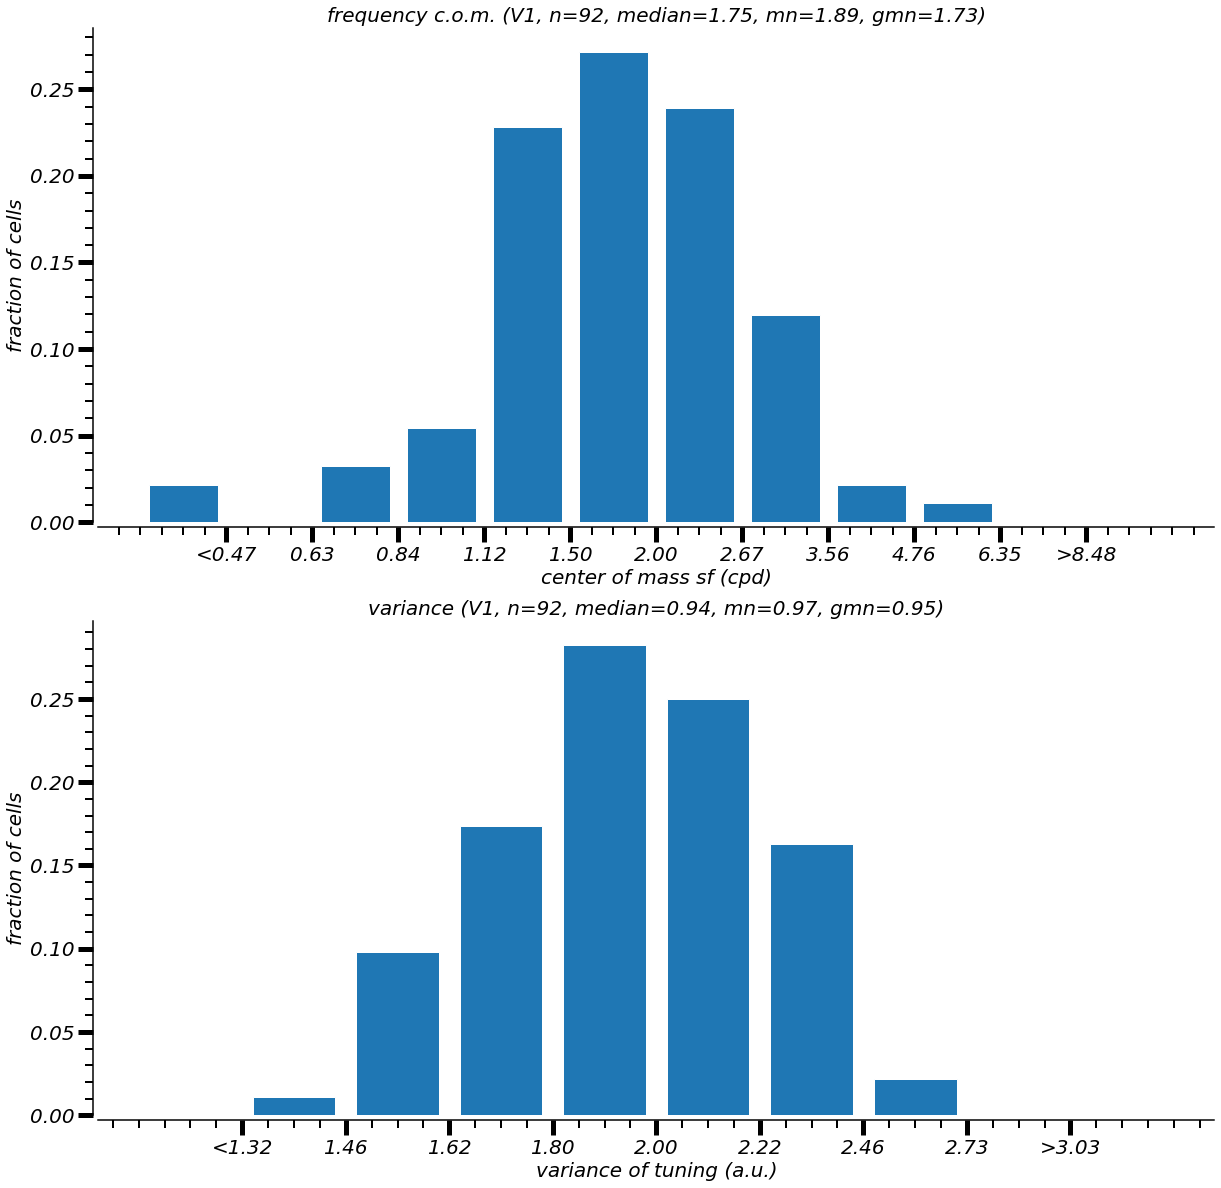

In [1836]:
matchBin = 1; # 1 if match bins to those used for descriptive pref Sf; 0 if not

binStr = '_binMatch' if matchBin else ''
saveName = '0_sfTuning_modelFree%s.pdf' % binStr

f, ax = plt.subplots(2, 1, figsize=(20, 20))

#######
# central tendency
#######
bins = pSfBins if matchBin else comBins;
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
coms_clipped = np.clip(hf.nan_rm(np.log2(comHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(coms_clipped);
medianSF = np.nanmedian(comHighCon);
mnSF = np.nanmean(comHighCon);
gmnSF = gmean(hf.nan_rm(comHighCon));

# plot
vals, _ = np.histogram(coms_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[0].set_xticks(tickVals);
ax[0].set_xticklabels(tickStrs, rotation=45);
sns.despine(ax=ax[0], offset=5)

ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('fraction of cells')
ax[0].set_title('frequency c.o.m. (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (whichArea, nSF, medianSF, mnSF, gmnSF));


#######
# variance
#######
bins = np.linspace(0.25, 1.75, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
vars_clipped = np.clip(hf.nan_rm(varHighCon), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(vars_clipped);
medianSF = np.nanmedian(varHighCon);
mnSF = np.nanmean(varHighCon);
gmnSF = gmean(hf.nan_rm(varHighCon));

# plot
vals, _ = np.histogram(vars_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(ax=ax[1], offset=5)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(tickStrs);

ax[1].set_xlabel('variance of tuning (a.u.)');
ax[1].set_ylabel('fraction of cells');
ax[1].set_title('variance (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (whichArea, nSF, medianSF, mnSF, gmnSF));

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()



#### Now, let's go to derived measures - i.e. measures of the tuning curve that rely on descriptive tuning functions

In [1837]:
disp = 0;
con = -1; # highest for single gratings
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in jointList.keys()])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in jointList.keys()])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in jointList.keys()])

### NEXT LINE IS TEMP: ensure all pSf estimates are > 0 (i.e. NEQ 0)
dog_pSfHighCon = np.maximum(np.array([jointList[i]['metrics']['dog_pSf'][disp][con] for i in jointList.keys()]), 0.1)
# dog_pSfHighCon = np.array([jointList[i]['metrics']['dog_pSf'][disp][con] for i in jointList.keys()])
dog_bwHalfHighCon = np.array([jointList[i]['metrics']['dog_bwHalf'][disp][con] for i in jointList.keys()])
dog_bw34HighCon = np.array([jointList[i]['metrics']['dog_bw34'][disp][con] for i in jointList.keys()])
dog_charFreqHighCon = np.array([jointList[i]['metrics']['dog_charFreq'][disp][con] for i in jointList.keys()])

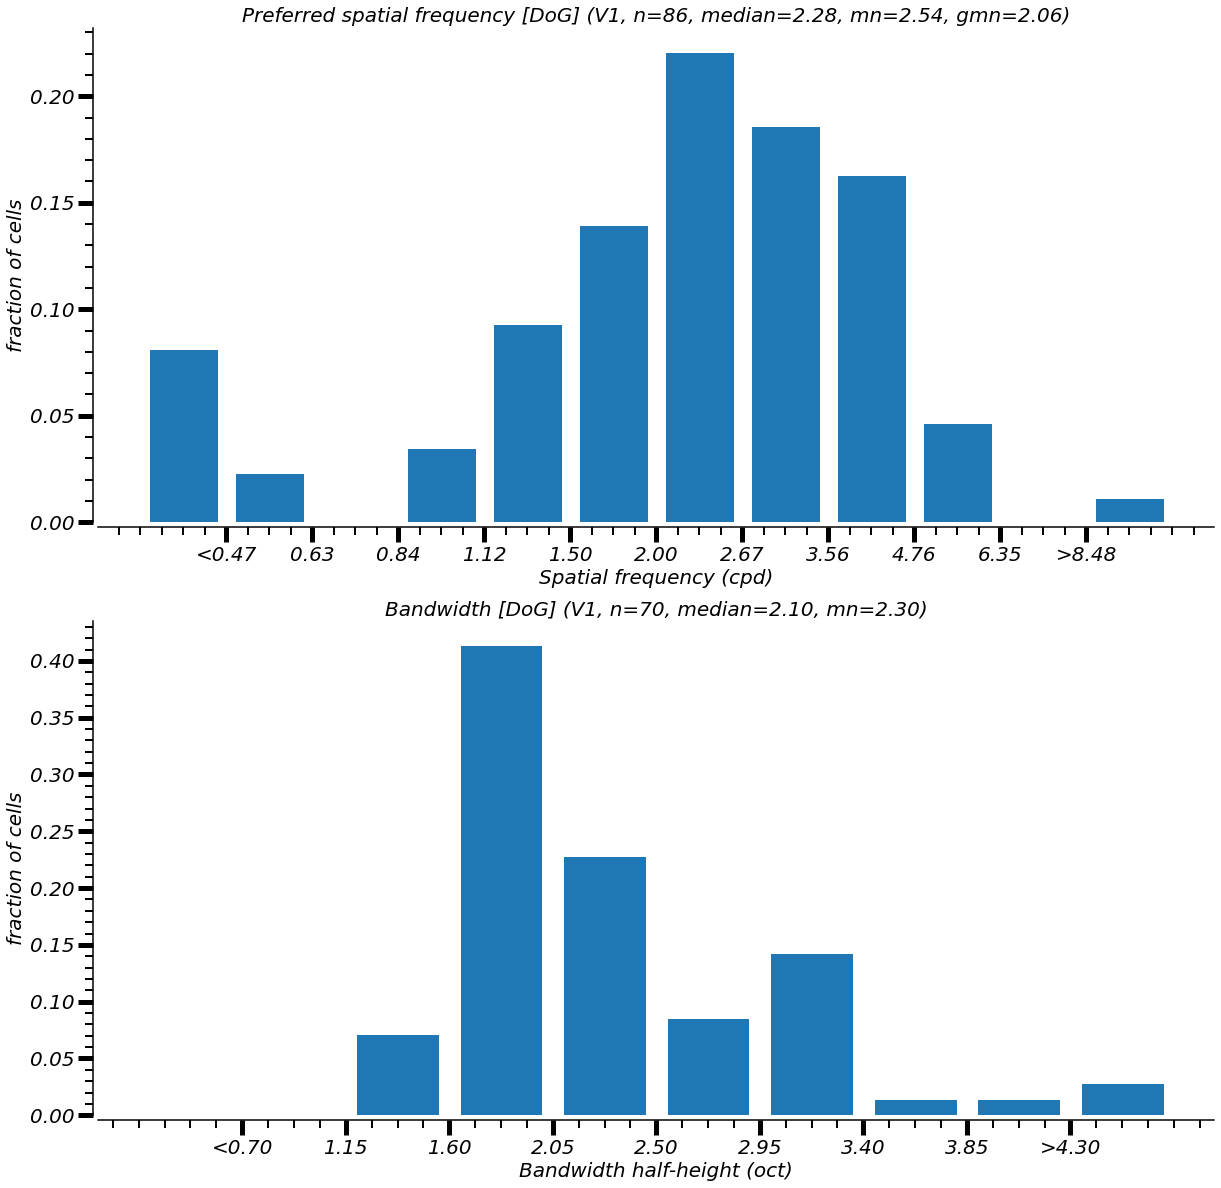

In [1838]:
whichMod = 1; # 0 for descr, 1 for DoG
halfHeight = 1; # 1 for half-height (bandwidth); 0 for 3/4th height

modStr = '_DoG' if whichMod else ''
dogStr = '[DoG] ' if whichMod else ''
bwStr = '_hh' if halfHeight else '_34h'
saveName = '0_sfTuning_descrFits%s%s.pdf' % (bwStr, modStr)

metric = dog_pSfHighCon if whichMod else pSfHighCon


f, ax = plt.subplots(2, 1, figsize=(20, 20))

#######
# SF
#######
bins = pSfBins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
sf_clipped = np.clip(hf.nan_rm(np.log2(metric)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(sf_clipped);
medianSF = np.nanmedian(metric);
mnSF = np.nanmean(metric);
gmnSF = gmean(hf.nan_rm(metric));

# plot
vals, _ = np.histogram(sf_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[0].set_xticks(tickVals);
ax[0].set_xticklabels(tickStrs, rotation=45);
sns.despine(ax=ax[0], offset=5)

ax[0].set_xlabel('Spatial frequency (cpd)')
ax[0].set_ylabel('fraction of cells')
ax[0].set_title('Preferred spatial frequency %s(%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (dogStr, whichArea, nSF, medianSF, mnSF, gmnSF));


#######
# Bandwidth
#######
metric = dog_bwHalfHighCon if whichMod else bwHalfHighCon
bandwidth_str = 'half-height' if halfHeight else '34-height'

bins = np.linspace(0.25, 4.75, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bw_clipped = np.clip(hf.nan_rm(metric), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nBW = len(bw_clipped);
medianBW = np.nanmedian(metric);
mnBW = np.nanmean(metric);

# plot
vals, _ = np.histogram(bw_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(ax=ax[1], offset=5)
tickStrs = ['%.2f' %x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(tickStrs);

ax[1].set_xlabel('Bandwidth %s (oct)' % bandwidth_str);
ax[1].set_ylabel('fraction of cells');
ax[1].set_title('Bandwidth %s(%s, n=%d, median=%.2f, mn=%.2f)' % (dogStr, whichArea, nBW, medianBW, mnBW));

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()



#### As an aside on the behavior of the flexible gaussian fit, let's plot the ratio of the $\sigma$ parameter at high to low contrast (per Tony's suggestion, 21.05.06)

In [1861]:
sigLow_h, sigLow_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=0)
sigUpper_h, sigUpper_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=1)


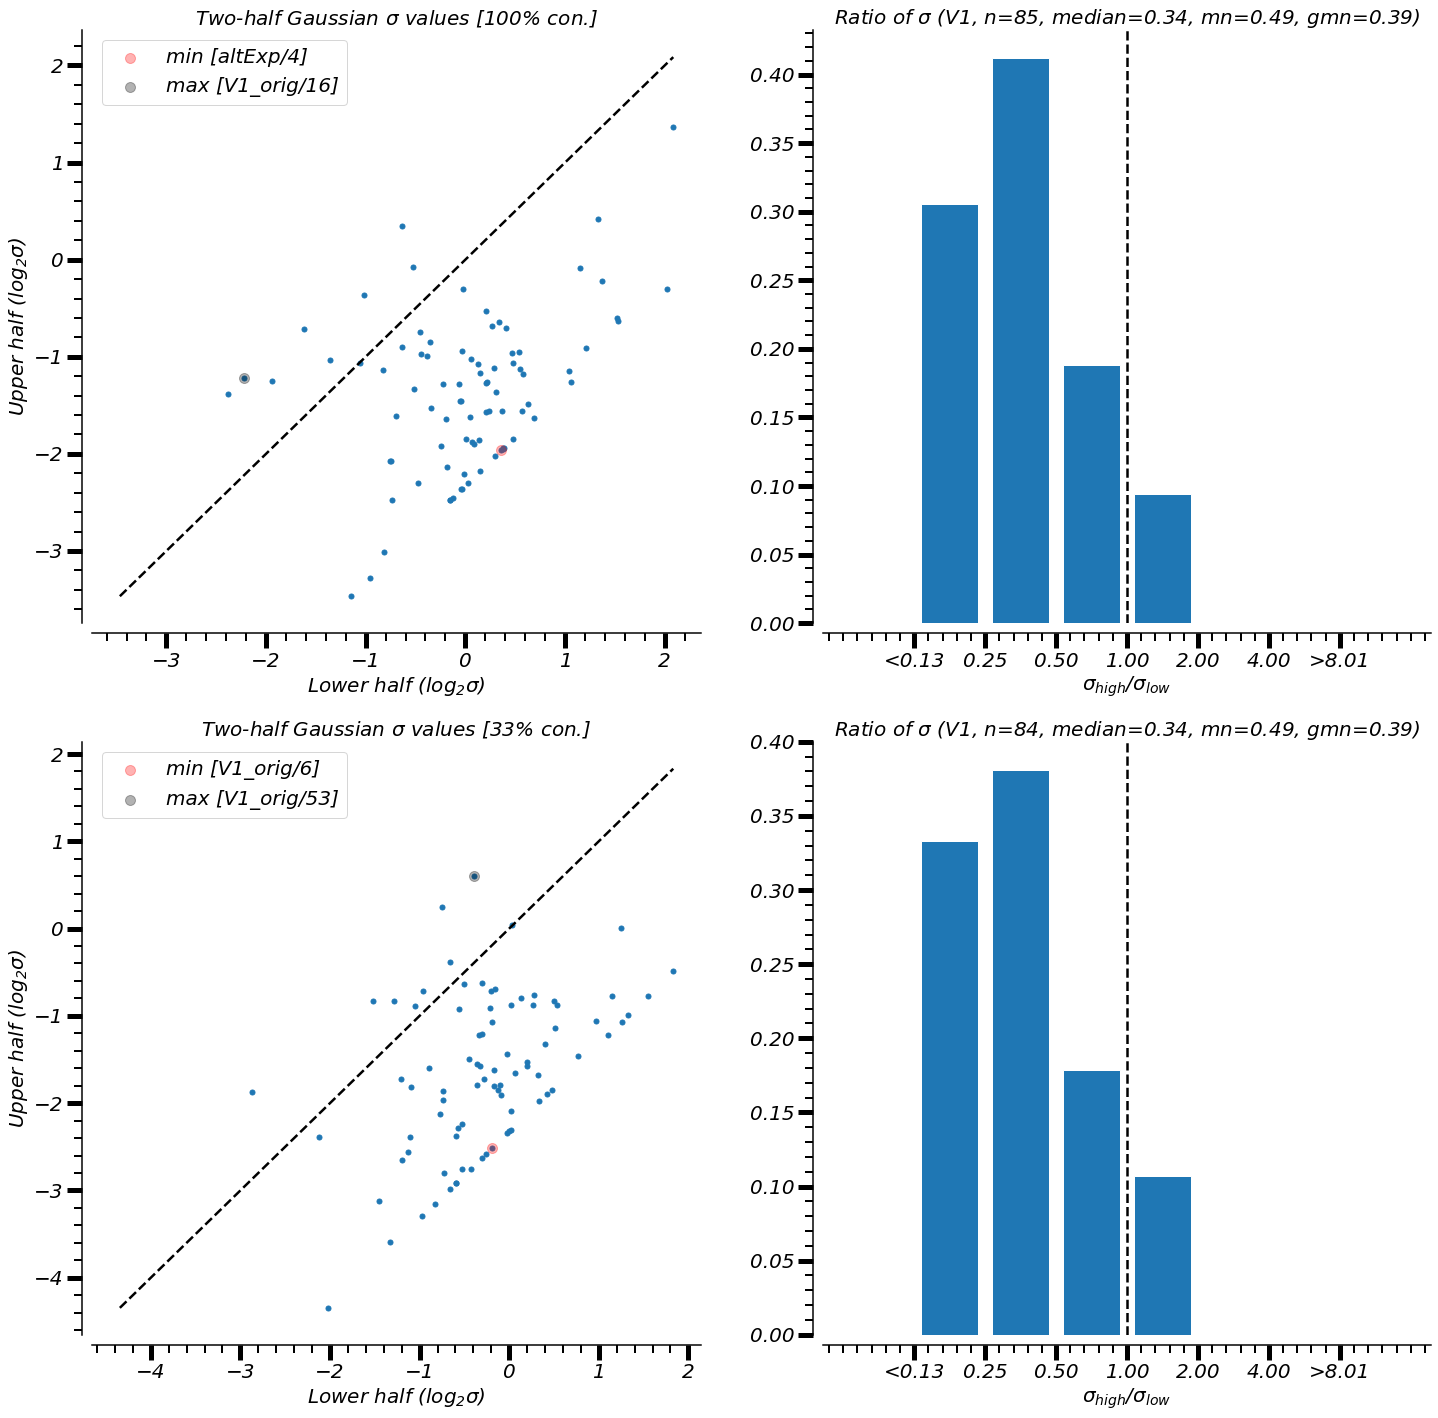

In [1862]:
fracSigmaUpper = 1; # is sigmaUpper given relative to lower?

saveName = '0_%s_flexGauss_sigma.pdf' % whichArea

# first 0 for disp; second 0 for 33% contrast (as oppposed to lowest valid con)
sigLow_h, sigLow_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=0)
sigUpper_h, sigUpper_l, _ = hf.jl_get_metric_highComp(jointList, 'bw_sigma', 0, 0, extraInds=1)
if fracSigmaUpper:
    sigUpper_h = np.multiply(sigLow_h, sigUpper_h)
    sigUpper_l = np.multiply(sigLow_l, sigUpper_l)

sigRats_h = np.divide(sigUpper_h, sigLow_h)
sigRats_l = np.divide(sigUpper_l, sigLow_l)

bins = np.linspace(-3.999, 4.001,9)
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

ratsAll = [sigRats_h, sigRats_l]
sigsAll = [[sigLow_h, sigUpper_h], [sigLow_l, sigUpper_l]]
labels = ['100% con.', '33% con.']

# - for the histogram plots, only
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];

nrow, ncol = 2, 2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12,nrow*12))#, sharey='col', sharex='col')

for (cI, rats), sigs, lbl in zip(enumerate(ratsAll), sigsAll, labels):

    ### First as scatter, than as histogram
    plt.axes(ax[cI, 0])
    minVal, maxVal = np.log2(np.minimum(np.nanmin(sigs[0]), np.nanmin(sigs[1]))), np.log2(np.maximum(np.nanmax(sigs[0]), np.nanmax(sigs[1])))
       
    plt.scatter(np.log2(sigs[0]), np.log2(sigs[1]))
    minInd, maxInd = np.nanargmin(rats), np.nanargmax(rats)
    extremaLabels = ['%s/%s' % (jointList[keysAsInts[i]]['metadata']['fullPath'].split('/')[-3], jointList[keysAsInts[i]]['metadata']['cellNum']) for i in [minInd, maxInd]]
    [plt.scatter(np.log2(sigs[0][i]), np.log2(sigs[1][i]), s=100, c=c, alpha=0.3, label='%s [%s]' % (st,st2)) for i,c,st,st2 in zip([minInd, maxInd], ['r','k'], ['min','max'], extremaLabels)]
    
    plt.plot([minVal, maxVal], [minVal, maxVal], 'k--')
    plt.xlabel(r'Lower half $(log_2{\sigma})$')
    plt.ylabel(r'Upper half $(log_2{\sigma})$')
    plt.title(r'Two-half Gaussian $\sigma$ values [%s]' % lbl)
    plt.legend()

    # HIST: calculate
    rats_clipped = np.clip(hf.nan_rm(np.log2(rats)), clipLow, clipHigh)
    nRat = len(rats_clipped)
    medianRat = np.nanmedian(rats)
    mnRat = np.nanmean(rats)
    gmnRat = gmean(hf.nan_rm(rats))
    
    plt.axes(ax[cI, 1])
    vals, _ = np.histogram(rats_clipped, bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel(r'$\sigma_{high}/\sigma_{low}$');
    plt.xticks(tickVals, tickStrs, rotation=30);
        
    plt.title(r'Ratio of $\sigma$ (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (whichArea, nRat, medianRat, mnRat, gmnRat));

sns.despine(offset=10)
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### Compare model-free and derived measures

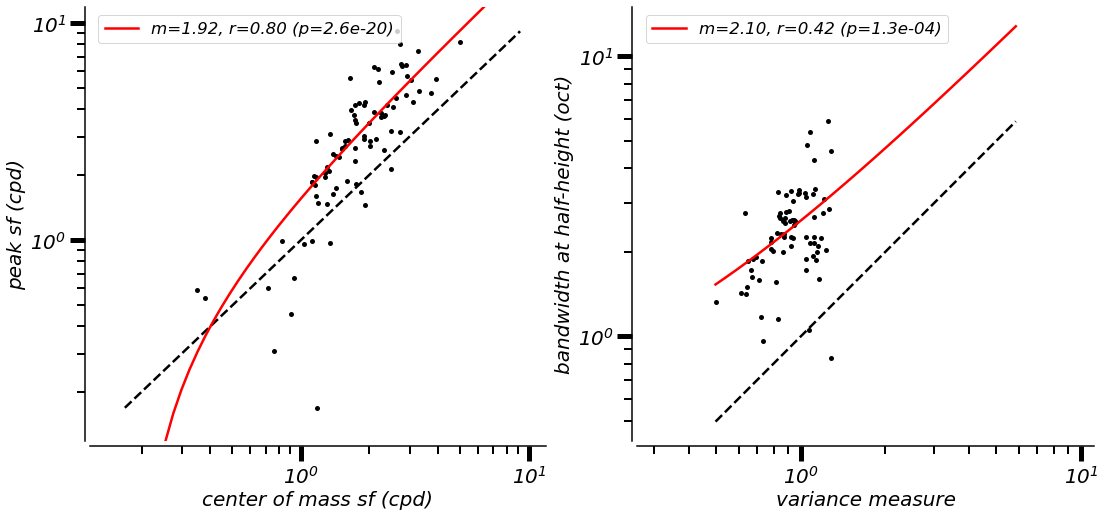

In [1567]:
whichMod = 0; # 0 for flex, 1 for DoG

modStr = '_DoG' if whichMod else ''
dogStr = '[DoG] ' if whichMod else ''


saveName = '0_descrVSmodFree%s.pdf' % (modStr)

descrMetric = dog_pSfHighCon if whichMod else pSfHighCon

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# central tendency
ax[0].loglog(comHighCon, descrMetric, 'o', c='k');
mn, mx = np.minimum(np.nanmin(comHighCon), np.nanmin(descrMetric)), np.maximum(np.nanmax(comHighCon), np.nanmax(descrMetric))
ax[0].loglog([mn, mx], [mn, mx], 'k--');
ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('peak sf %s(cpd)' % dogStr)
non_nan = np.logical_and(~np.isnan(comHighCon), ~np.isnan(descrMetric))
slope, intercept, r, p, err = linregress(comHighCon[non_nan], descrMetric[non_nan])
plt_vals = np.geomspace(mn, mx, 50);
ax[0].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[0].legend(fontsize='small');
ax[0].set_xlim([mn*0.7, 1.3*mx])
ax[0].set_ylim([mn*0.7, 1.3*mx])
# ax[0].axis('equal')
sns.despine(ax=ax[0], offset=5)

# variance
descrMetric = dog_bwHalfHighCon if whichMod else bwHalfHighCon

ax[1].loglog(varHighCon, descrMetric, 'o', c='k');
mn, mx = np.minimum(np.nanmin(varHighCon), np.nanmin(descrMetric)), np.maximum(np.nanmax(varHighCon), np.nanmax(descrMetric))
ax[1].loglog([mn, mx], [mn, mx], 'k--');
ax[1].set_xlabel('variance measure')
ax[1].set_ylabel('bandwidth at half-height %s(oct)' % dogStr)
non_nan = np.logical_and(~np.isnan(varHighCon), ~np.isnan(descrMetric))
slope, intercept, r, p, err = linregress(varHighCon[non_nan], descrMetric[non_nan])
plt_vals = np.geomspace(mn, mx, 50);
ax[1].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[1].legend(fontsize='small');
ax[1].axis('equal')
sns.despine(ax=ax[1], offset=5)


# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

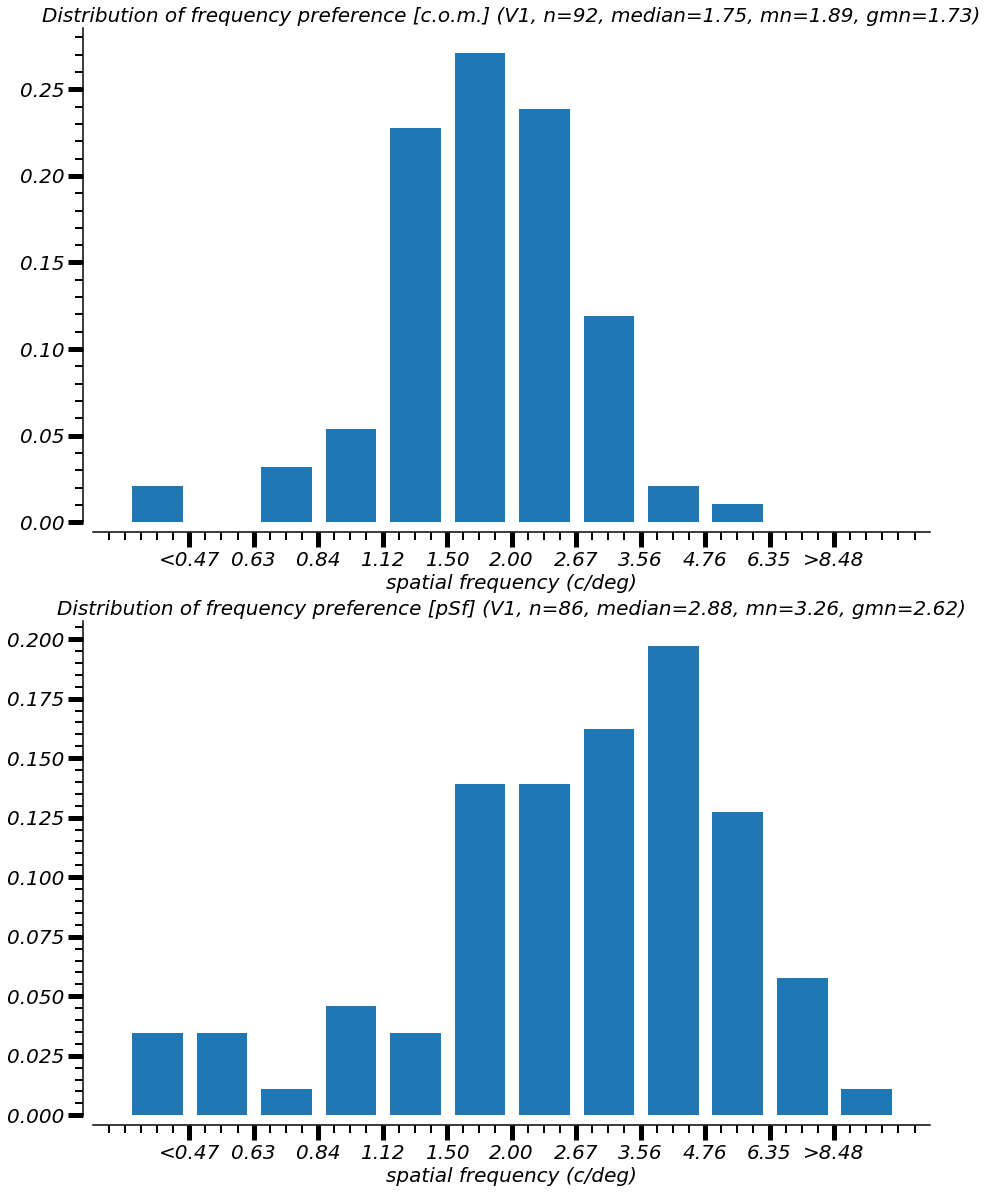

In [1727]:
whichMod = 0; # 0 for flex, 1 for DoG

modStr = '_DoG' if whichMod else ''
saveName = '0_descrVSmodFree_onlyPrefSf%s.pdf' % (modStr)

f, ax = plt.subplots(2, 1, figsize=(15, 2*10))

# gather and calculate
metric = dog_pSfHighCon if whichMod else pSfHighCon

bins = pSfBins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [comHighCon, metric];
fitStr = ['c.o.m.', 'pSf']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], whichArea, nSF[i], medianSF[i], mnSF[i], gmnSF[i]));
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### Cavanaugh dataset
Now, let's load the Cavanaugh (?) dataset sent to me by Tony

In [795]:
cv_file = 'v1-jrc-cavanaugh.xls'
df = pd.read_excel(cv_file);

In [796]:
# What are the columns?
df.keys()

Index(['Casename', 'AREA', 'PEN     ', 'HEMI    ', 'DEPTH   ', 'LAYER   ',
       'SCRDIST ', 'pixpercm', 'qual-OD      ', 'qual-rsp', 'qual-ISOL    ',
       'qual-rfx', 'qual-rfy', 'rfeccen', 'qual-rfsz', 'complexity',
       'class(s1,c0)', 'prefori', 'direct', 'oriwid', 'vectprefori',
       'vectprefdir', 'vectoribias', 'vectdirbias', 'optsf', 'sfwid', 'sfqual',
       'opttf', 'tfwid', 'tfqual', 'dataoptszdg', 'fitoptszdg', 'dsuprsp',
       'datasuppidx', 'fitsuppidx'],
      dtype='object')

In [797]:
### what do we want to get
# first, get the restricted set
eccBounds = [2, 6]
ecc_match = np.logical_and(df['rfeccen']>eccBounds[0], df['rfeccen']<eccBounds[1])
ecc_inds = np.where(ecc_match)[0]

# pref Sf
cav_psf = df['optsf'];
cav_psfEcc = df['optsf'][ecc_inds]

# sf BW
cav_sfBw = df['sfwid'];
cav_sfBwEcc = df['sfwid'][ecc_inds]

##### Cav: prefSF

In [1090]:
bins = pSfBins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [cav_psf, cav_psfEcc];
fitStr = ['full', 'ecc-match']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

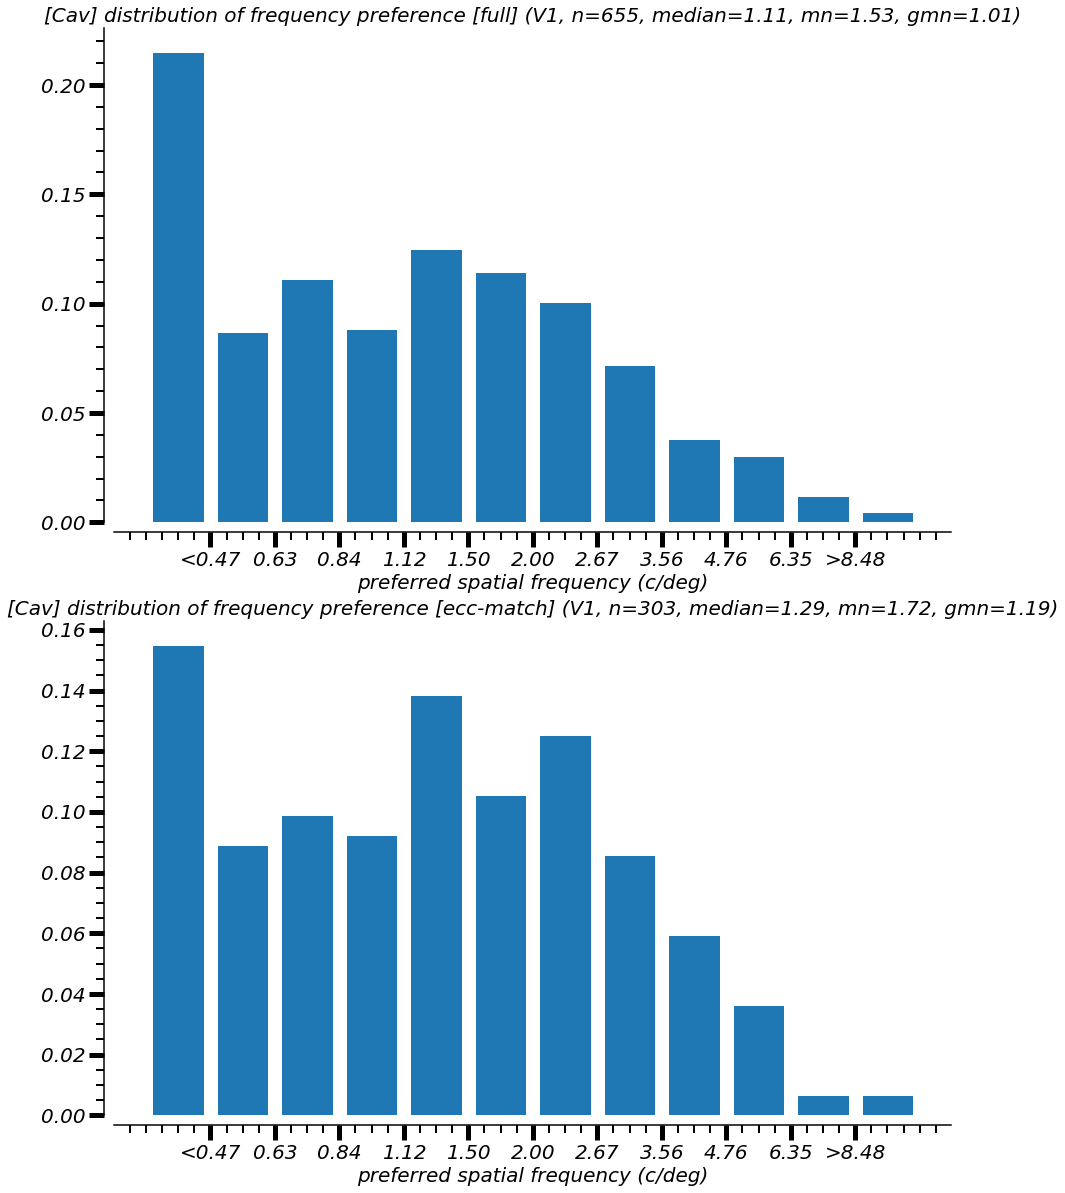

In [1091]:
saveName = '0_z_ref_cavanaugh_SF.pdf'

f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('preferred spatial frequency (c/deg)');
    plt.title('[Cav] distribution of frequency preference [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));

    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Cav: bandwidth

First, we ask: are the bandwidths given in octaves or linear c/deg?

In [1092]:
all_ok = np.logical_and(~np.isnan(cav_psf), ~np.isnan(cav_sfBw))
fit_mod = np.polyfit(cav_psf[all_ok], cav_sfBw[all_ok], deg=1)

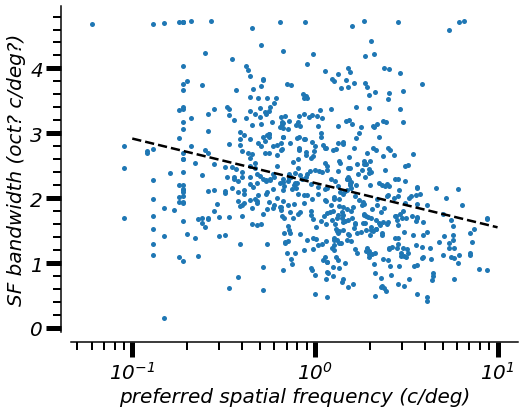

In [801]:
all_ok = np.logical_and(~np.isnan(cav_psf), ~np.isnan(cav_sfBw))
# returns a, b in a*x + b
fit_mod = np.polyfit(np.log2(cav_psf[all_ok]), cav_sfBw[all_ok], deg=1)

plt.subplots(figsize=(8, 6))
plt.plot(cav_psf, cav_sfBw, 'o')
# plot the linear fit on log-lin (x-y) coords.
all_sfs = np.geomspace(0.1, 10, 100);
plt.plot(all_sfs, np.log2(all_sfs)*fit_mod[0] + fit_mod[1], 'k--')
plt.xscale('log')
plt.xlabel('preferred spatial frequency (c/deg)')
plt.ylabel('SF bandwidth (oct? c/deg?)')
sns.despine(offset=10, trim=False)

The relative lack of (or even slightly negative) correlation between preferred spatial frequency and bandwidth measure suggests that the latter measure is given in octaves, not linear cycles per degree. Why? Well, neurons with higher preferred SF have a larger __linear__ bandwidth, but generally __octave__ bandwidth remains constant as a function of preferred SF.

In [1093]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

sfBWs = [cav_sfBw, cav_sfBwEcc];
fitStr = ['full', 'ecc-match']

bw_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in sfBWs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nBW = [len(x) for x in bw_clipped]
medianBW = [np.nanmedian(x) for x in sfBWs];
mnBW = [np.nanmean(x) for x in sfBWs];

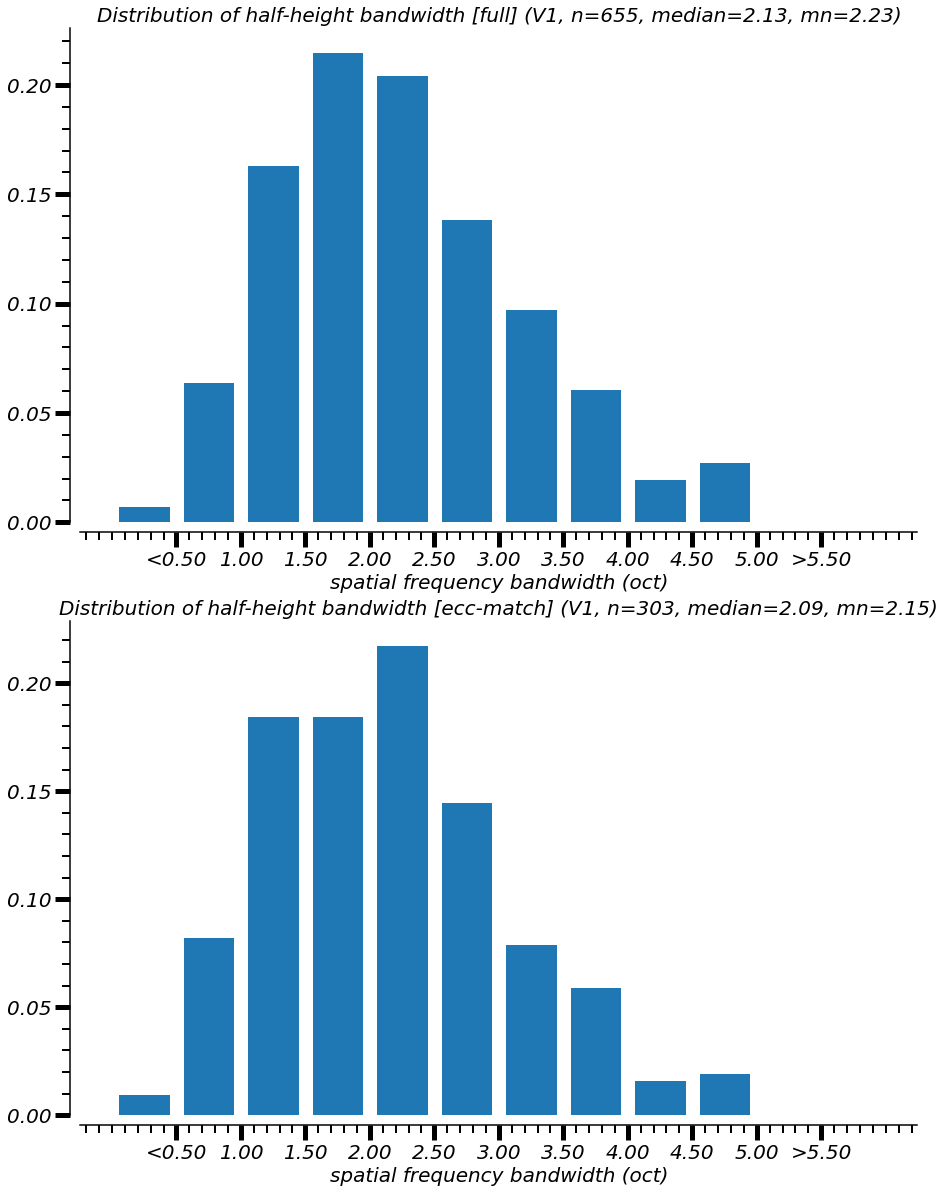

In [1094]:
saveName = '0_z_ref_cavanaugh_BW.pdf'

f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(bw_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('spatial frequency bandwidth (oct)');
    plt.title('Distribution of half-height bandwidth [%s] (%s, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nBW[i], medianBW[i], mnBW[i]));
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### (return to my data) Plot the distribution of preferred frequency:

In [805]:
bins = pSfBins
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [pSfHighCon, dog_pSfHighCon];
fitStr = ['flex', 'DoG']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

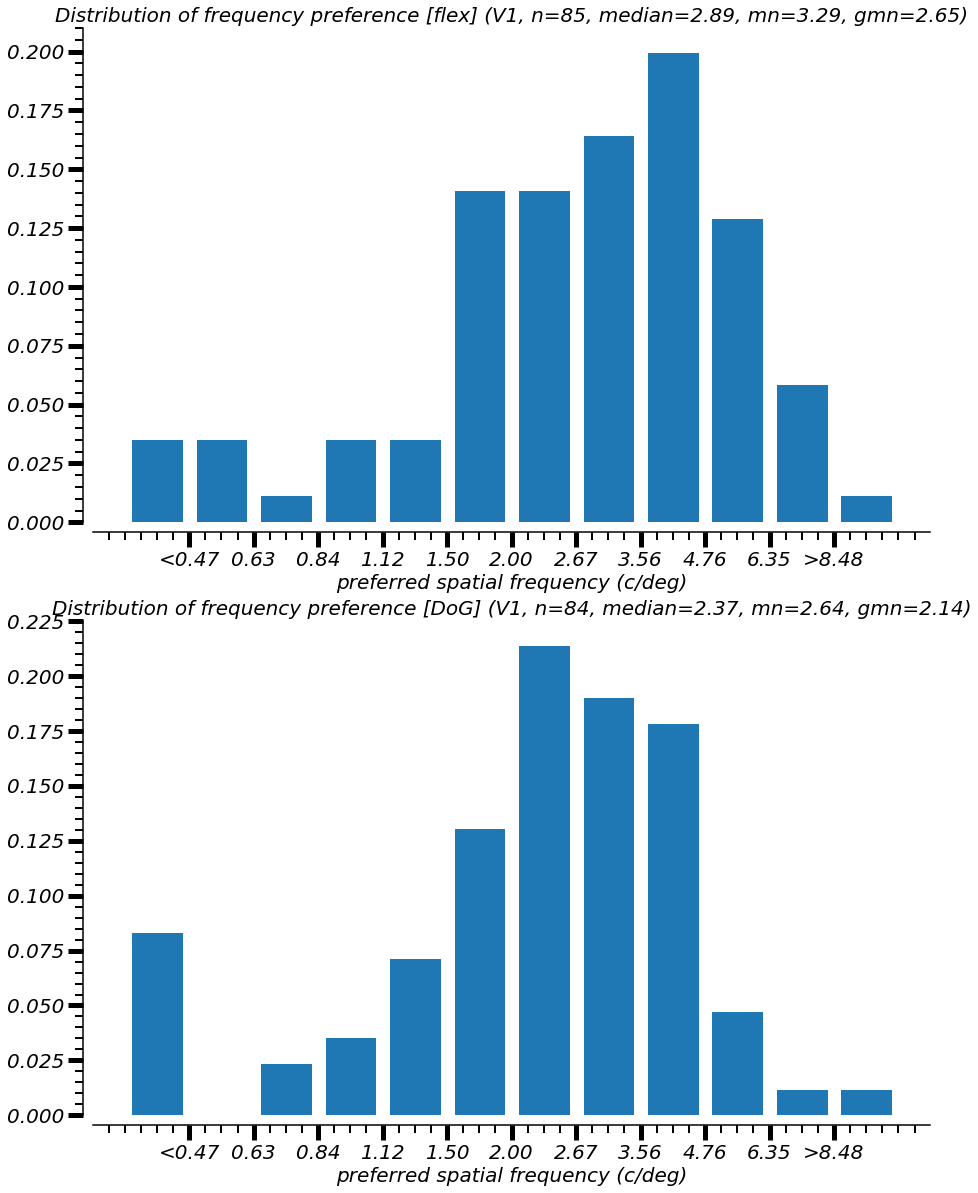

In [806]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('preferred spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


##### Compare to existing measurements:

**DeValois, Albrecht, Thorell (1982):**
Here, they split their data by X&Y, foveal ($[0^{\circ}, 1.5^{\circ}]$) and parafoveal ($[3^{\circ}, 5^{\circ}]$). Our data are parafoveal if not further, so we expect that our distribution of peak frequencies will be comparable to their X/Y parafoveal data, if not shifted lower, since we expect a fall-off in peak frequency with eccentricity (i.e., the highest peak frequency drops as a function of eccentricity, [DeValois & DeValois, 1980]). They have a mean of 2.2/3.2 cpd for Y/X parafoveal cells; our mean/gmean is 3.45/2.76 cpd. **Our cells are "in the ballpark".**

<img src="figures/dv-sf.png" width=400 />

**Cavanaugh (intra-lab dataset):**
See the above - his distribution has a substantially lower preferred spatial frequency (mean between 1.5 - 1.7 cpd, depending on full or eccentricity-matched dataset).

#### Plot the distribution of characteristic frequency:

In [1095]:
bins = np.linspace(-0.5, 4.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

char_clipped = np.clip(hf.nan_rm(np.log2(dog_charFreqHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nCF = len(char_clipped)
medianCF = np.nanmedian(dog_charFreqHighCon)
mnCF = np.nanmean(dog_charFreqHighCon);
gmnCF = gmean(hf.nan_rm(dog_charFreqHighCon));

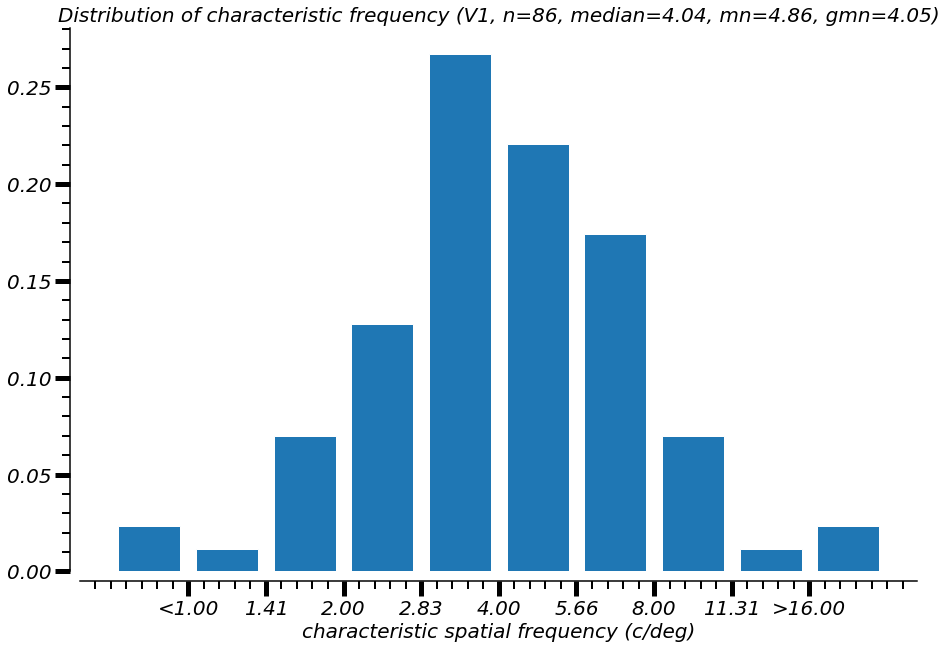

In [1096]:
saveName = '0_sfTuning_charFreq.pdf'

f, ax = plt.subplots(figsize=(15, 10))

vals, _ = np.histogram(char_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('characteristic spatial frequency (c/deg)');
plt.title('Distribution of characteristic frequency (%s, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nCF, medianCF, mnCF, gmnCF));

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


#### Plot the distribution of frequency tuning bandwidth:

First, half-height

In [542]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bwHalfClipped = np.clip(hf.nan_rm(bwHalfHighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bwHalfClipped);
medianBW = np.nanmedian(bwHalfHighCon);
mnBW = np.nanmean(bwHalfHighCon);

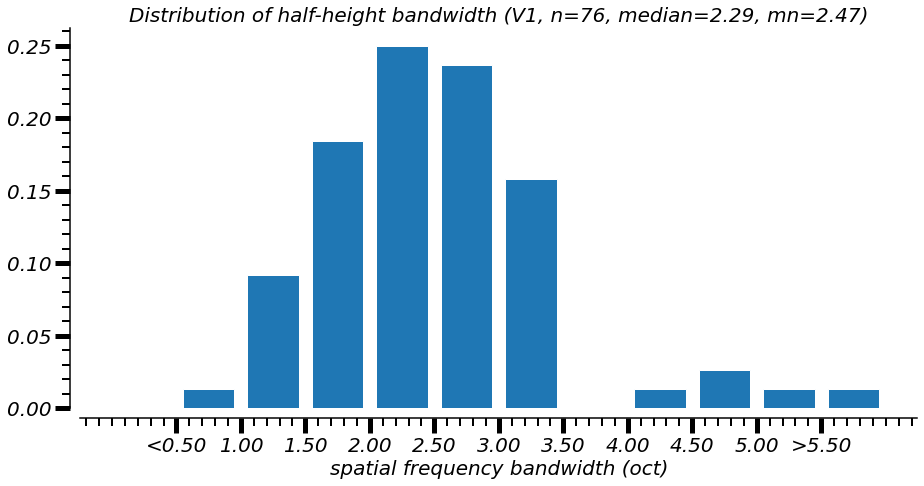

In [543]:
f, ax = plt.subplots(figsize=(15, 7))
# ax.set(xscale="log")

vals, _ = np.histogram(bwHalfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of half-height bandwidth (%s, n=%d, median=%.2f, mn=%.2f)' % (nBW, medianBW, mnBW));

#### Compare to existing measurements:

**DeValois, Albrecht, Thorell (1982):**
Here, they split their data by X&Y, foveal ($[0^{\circ}, 1.5^{\circ}]$) and parafoveal ($[3^{\circ}, 5^{\circ}]$). 
Our data are parafoveal if not further, so we expect that our distribution of bandwidth will be comparable to their X/Y parafoveal data. They have a mean of 1.6/1.32 octaves for Y/X parafoveal cells; our mean/median is 2.45/2.77 octaves. **Our cells are more broadly tuned. Why?**

<img src="figures/dv-bw.png" width=400 />

**Cavanaugh (intra-lab dataset):**
Our bandwidth measures are comparable (median/mean around 2.1/2.2 octaves), though ours are still broader. Note that we have assumed his measurements are given in octaves (and not linear CPD).

Then, three-fourth height

In [544]:
bins = np.linspace(0, 4, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bw34Clipped = np.clip(hf.nan_rm(bw34HighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bw34Clipped);
medianBW = np.nanmedian(bw34HighCon);
mnBW = np.nanmean(bw34HighCon);

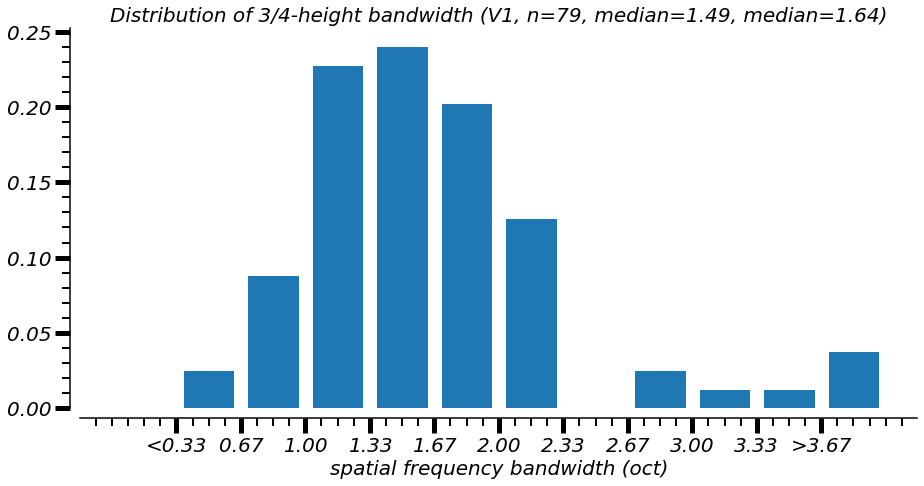

In [545]:
f, ax = plt.subplots(figsize=(15, 7))
vals, _ = np.histogram(bw34Clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of 3/4-height bandwidth (%s, n=%d, median=%.2f, median=%.2f)' % (nBW, medianBW, mnBW));

### Relating fit quality to fit parameters

In [1498]:
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in jointList.keys()])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in jointList.keys()])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in jointList.keys()])
# then the same, but for DoG fits
dog_pSfHighCon = np.array([jointList[i]['metrics']['dog_pSf'][disp][con] for i in jointList.keys()])
dog_bwHalfHighCon = np.array([jointList[i]['metrics']['dog_bwHalf'][disp][con] for i in jointList.keys()])
dog_bw34HighCon = np.array([jointList[i]['metrics']['dog_bw34'][disp][con] for i in jointList.keys()])

### How correlated are the inferred measures from the two descriptive SF fits?

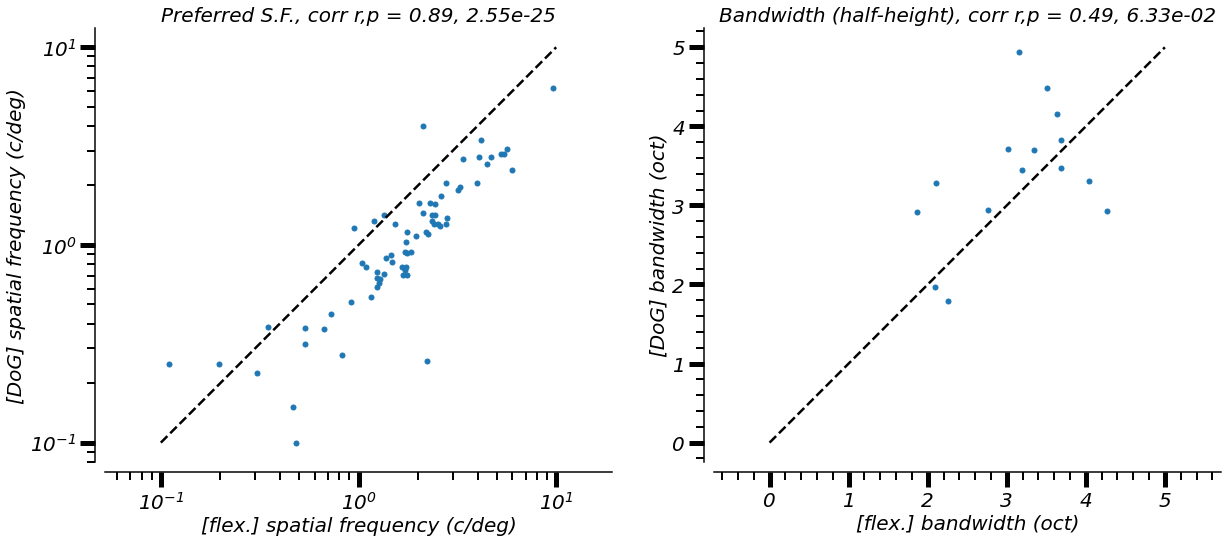

In [1499]:
saveName = '0_sfTuning_compareDescrs.pdf'

nrow, ncol = 1, 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10, nrow*8))


# first, C.o.M. and pSF
metrics = [[pSfHighCon, dog_pSfHighCon], [bwHalfHighCon, dog_bwHalfHighCon]];
labels = ['Preferred S.F.', 'Bandwidth (half-height)'];
axlabels = ['spatial frequency (c/deg)', 'bandwidth (oct)']
xVy_prefix = ['flex.', 'DoG']
lims = [[1e-1, 1e1], [0, 5]]
for ind, (m, l, axlbl, lim) in enumerate(zip(metrics, labels, axlabels, lims)):
    ax[ind].scatter(m[0], m[1])
    
    no_nan = np.where(np.logical_and(~np.isnan(m[0]), ~np.isnan(m[1])))
    
    slope, intercept, r, p, err = linregress(m[0][no_nan], m[1][no_nan])
    
    ax[ind].set_xlabel('[%s] %s' % (xVy_prefix[0], axlbl));
    ax[ind].set_ylabel('[%s] %s' % (xVy_prefix[1], axlbl));
    ax[ind].set_title('%s, corr r,p = %.2f, %.2e' % (l, r, p))
    ax[ind].axis('equal')
    if ind == 0:
        ax[ind].set_xscale('log')
        ax[ind].set_yscale('log')
    ax[ind].set_xlim(lim)
    ax[ind].plot(lim, lim, 'k--')

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


So, it seems that preferred frequency is more reliable across the two descriptive fits than is bandwidth. However, there is a bias, in which the flexible Gaussian (i.e. two-halved Gaussian) estimates systemetically higher preferred frequencies than we see in the difference of Gauss fit. As for bandwidth, the flexible Gaussian has a greater range of fitted bandwidths (note the horizontal-only dispersion around y=1.8 octaves)

In [1602]:
dispInd, conInd = 0, -1;
# for high contrast, single gratings
descrVarExpl = [jointList[x]['metrics']['sfVarExpl'][dispInd][conInd] for x in jointList.keys()]
dogVarExpl = [jointList[x]['metrics']['dog_varExpl'][dispInd][conInd] for x in jointList.keys()]

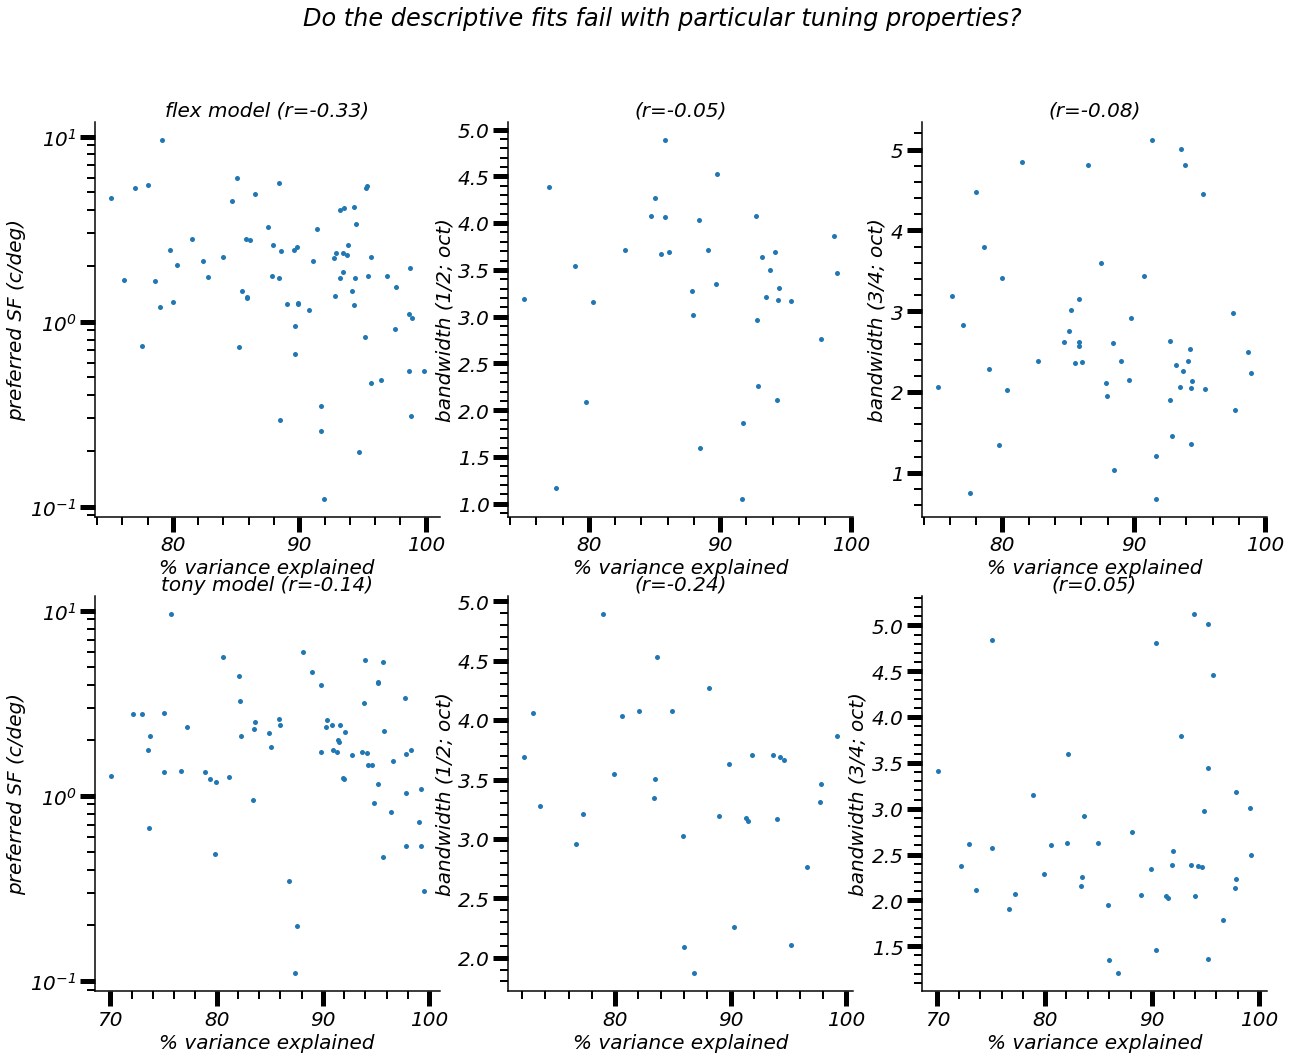

In [1501]:
saveName = '0_sfTuning_corrWithVarExpl.pdf'

nMods, nComps = 2, 3;
f, ax = plt.subplots(nMods, nComps, figsize=(nComps*7, nMods*8))

allVar = [descrVarExpl, dogVarExpl];
modStr = [hf.descrMod_name(0), hf.descrMod_name(2)]; # 0 [flex], 1 [sach], 2[tony]

f.suptitle('Do the descriptive fits fail with particular tuning properties?')

for i in range(len(allVar)):

    ### compute the correlations
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(pSfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], pSfHighCon[~jointNan])
    rSf = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bwHalf
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bwHalfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bwHalfHighCon[~jointNan])
    rBw = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bw34
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bw34HighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bw34HighCon[~jointNan])
    rBw34 = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    
    # first, varExpl vs. prefSf
    ax[i, 0].semilogy(allVar[i], pSfHighCon, 'o')
    ax[i, 0].set_xlabel('% variance explained')
    ax[i, 0].set_ylabel('preferred SF (c/deg)')
    ax[i, 0].set_title('%s model (r=%.2f)' %  (modStr[i], rSf));
    # then, varExpl vs. sfBw (1/2)
    ax[i, 1].plot(allVar[i], bwHalfHighCon, 'o')
    ax[i, 1].set_xlabel('% variance explained')
    ax[i, 1].set_ylabel('bandwidth (1/2; oct)')
    ax[i, 1].set_title('(r=%.2f)' % rBw)
    # finally, varExpl vs. sfBw (3/4)
    ax[i, 2].plot(allVar[i], bw34HighCon, 'o')
    ax[i, 2].set_xlabel('% variance explained')
    ax[i, 2].set_ylabel('bandwidth (3/4; oct)')
    ax[i, 2].set_title('(r=%.2f)' % rBw34)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## 1. Simple vs complex
How do the tuning properties above vary with F1/F0 ratio? Here, I compute the F1/F0 ratio based on the responses to the optimial single grating SF at high contrast. I take the F0 and F1 values for each repeat of that condition, and compute the mean of all individual trial ratios.

In [1502]:
nCells = len(jointList)
f1f0_rats = np.array([jointList[i]['metrics']['f1f0_ratio'] for i in jointList.keys()])
f1f0_saveName = '1_simple_complex_distr.pdf'

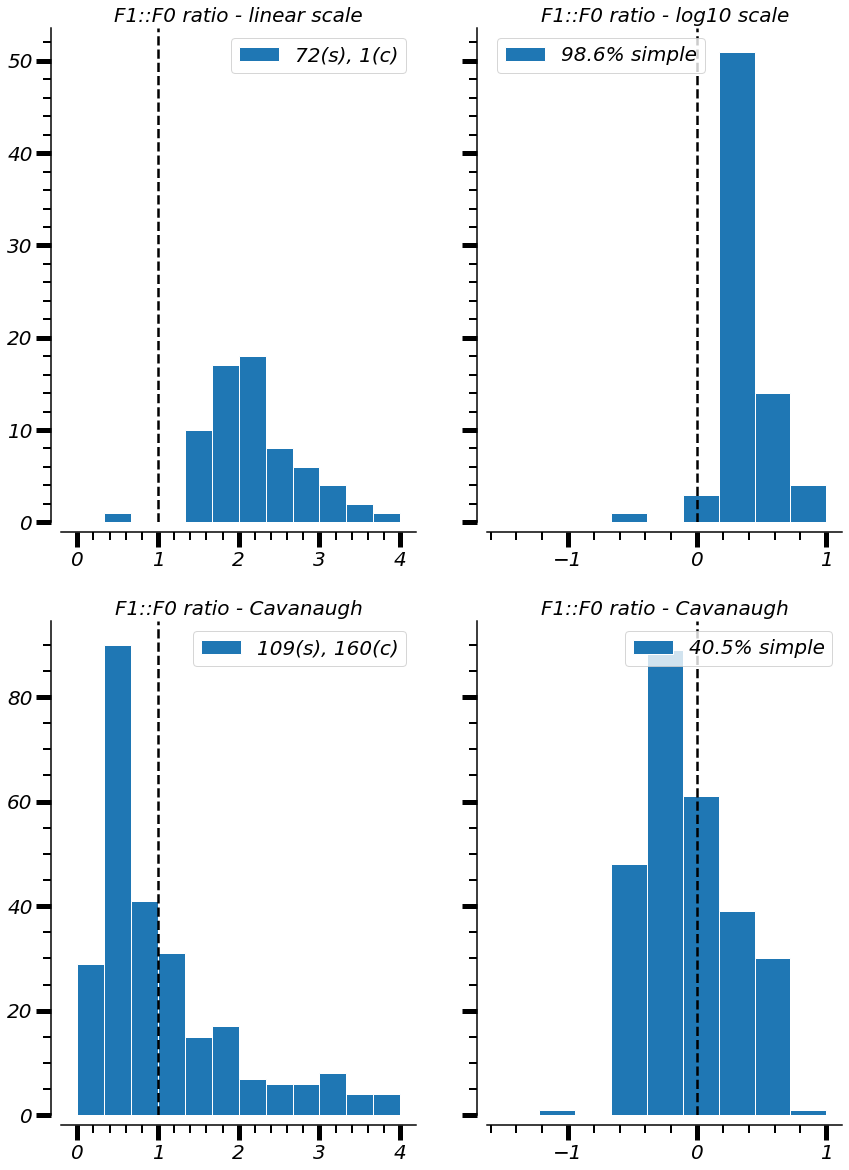

In [1503]:
nRows, nCols = 2, 2
f, ax = plt.subplots(nRows, nCols, figsize=(nCols*7, nRows*10), sharey='row')


# NOTE: Cavanaugh's F1F0 ratio seems to be in the 'complexity' field, and is already log(base10) transformed
logbins = np.linspace(-1.5, 1, 10)
linbins = np.linspace(0,4,13)

cav_complexity = hf.nan_rm(df['complexity'])
c_nS, c_nC = sum(cav_complexity>0), sum(cav_complexity<0)
bins = ax[1, 1].hist(cav_complexity, bins=logbins, label='%.1f%% simple' % (100*(c_nS/(c_nS+c_nC))))[1];
ax[1, 1].axvline(0, ls='--', color='k');
ax[1, 1].set_title('F1::F0 ratio - Cavanaugh')
ax[1, 1].legend();
# -- and Cavanaugh, but not log10
linbins = ax[1, 0].hist(hf.nan_rm(np.power(10, cav_complexity)), bins=linbins, label='%d(s), %d(c)' % (c_nS, c_nC))[1];
ax[1, 0].axvline(1, ls='--', color='k');
ax[1, 0].set_title('F1::F0 ratio - Cavanaugh')
ax[1, 0].legend();

# then, my data
nS, nC = sum(f1f0_rats>1), sum(f1f0_rats<1)
linbins = ax[0, 0].hist(hf.nan_rm(f1f0_rats), bins=linbins, label='%d(s), %d(c)' % (nS, nC));
ax[0, 0].axvline(1.0, ls='--', color='k');
ax[0, 0].set_title('F1::F0 ratio - linear scale')
ax[0, 0].legend();

fracS = nS/(nS+nC);
ax[0, 1].hist(hf.nan_rm(np.log10(f1f0_rats)), bins=bins, label='%.1f%% simple' % (100*fracS));
ax[0, 1].axvline(0, ls='--', color='k');
ax[0, 1].set_title('F1::F0 ratio - log10 scale')
ax[0, 1].legend();

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0_saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


From the above plots, we can see that the f1/f0 ratios in my V1 dataset are _somewhat_ comparable to Cavanaugh's, both in "sign" and magnitude

In [1102]:
f1f0tuning_name = '1_f1f0_tuning.pdf';

In [1103]:
# using for colors
zTO1 = lambda x: np.divide(x - np.nanmin(x), np.nanmax(x - np.nanmin(x)));

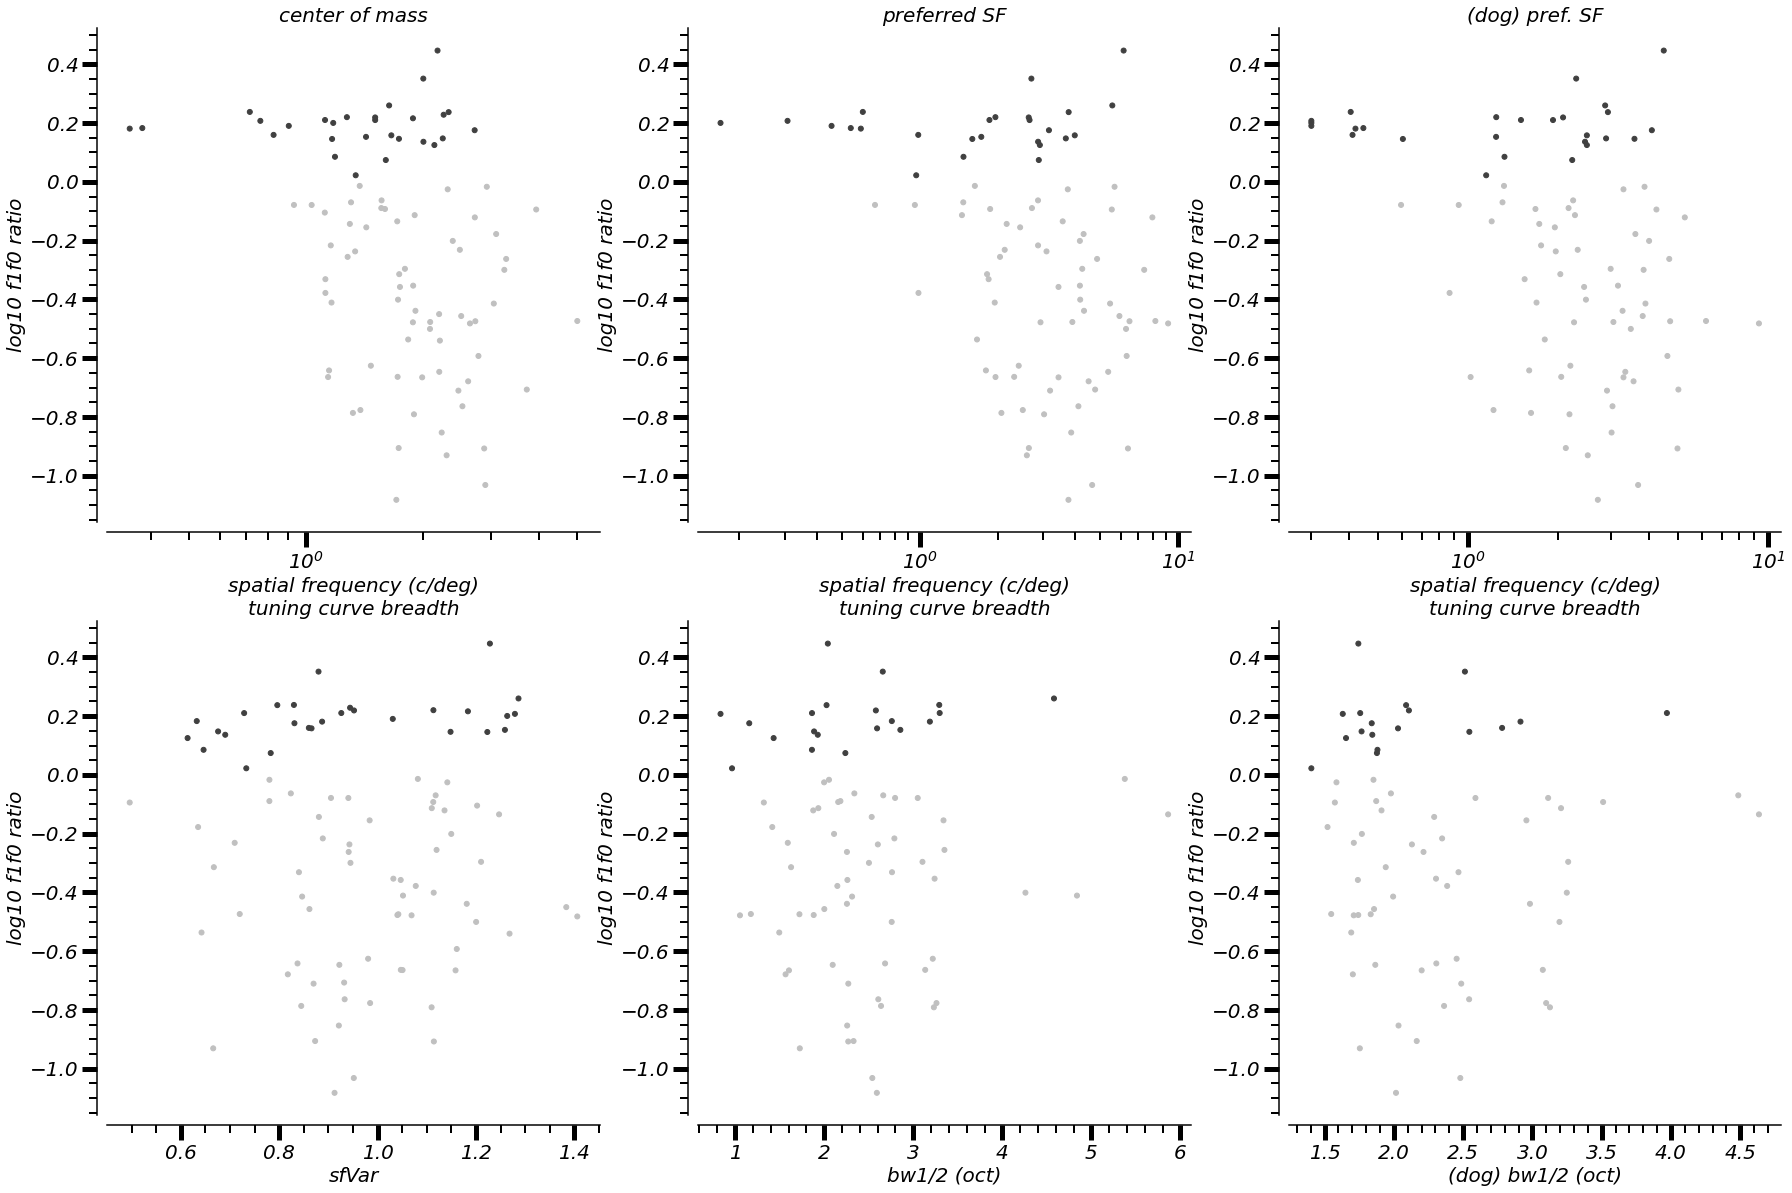

In [1104]:
nCols = 3; # each of the below measures will have two types to analyze
nMeasure = 2; # central tendency of SF, variance of S

f, ax = plt.subplots(nMeasure, nCols, figsize=(10*nCols, 10*nMeasure));
# we'll color each point according to the log10'd f1f0 ratio (this scale is more uniform)
log10_f1f0rats = np.log10(f1f0_rats);
clrs = cm.gray(np.ones_like(log10_f1f0rats) - 0.75);
lt0 = np.where(log10_f1f0rats < 0)[0];
clrs[lt0, :] = cm.gray(np.ones_like(lt0) - 0.25);
# clrs = cm.gray(zTO1(log10_f1f0rats));

# first, C.o.M. and pSF
metrics = [comHighCon, pSfHighCon, dog_pSfHighCon];
labels = ['center of mass', 'preferred SF', '(dog) pref. SF'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[0, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[0, ind].set_ylabel('log10 f1f0 ratio');
    ax[0, ind].set_xlabel('spatial frequency (c/deg)');
    ax[0, ind].set_title('%s' % l)
    ax[0, ind].set_xscale('log')

# second, sfVar and bwHalf
metrics = [varHighCon, bwHalfHighCon, dog_bwHalfHighCon];
labels = ['sfVar', 'bw1/2 (oct)', '(dog) bw1/2 (oct)'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[1, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[1, ind].set_ylabel('log10 f1f0 ratio');
    ax[1, ind].set_xlabel('%s' % l);
    ax[1, ind].set_title('tuning curve breadth')
    
sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0tuning_name);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


Per a discussion with MJH on 20.03.26, he said that there was substantial overlap in the preferred SF of simple and complex cells, but a small group of simple cells had (MAYBE) lower preferred SF than was typically seen in complex cells, and somewhat lower bandwidths. The preferred frequency observation holds here, though bandwidth is less distinct 

## 2. Shifts in tuning with contrast

### Preferred spatial frequency with contrast inferred from descriptive fit to pSf vs. con

Now, we plot the ratio of preferred spatial frequencies in the data set. Here, we are using "pSfModRat" - a derived measure in which we fit a simple polynomial equation to the preferred frequencies as a function of contrast (see descr_fits.py for details).

- In [0, 0], the ratio of preferred spatial frequencies ($\frac{con_a}{con_b}$) evaluated at the extrema contrasts
- In [0, 1], the ratio of preferred spatial frequencies is expressed per unit log2 contrast

In [1507]:
centerBin = 1; # if 1, then the middle bin will be centered at 0

whichFit = 0 # 0 for flexible gauss, 1 for DoG

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

if centerBin == 1:
    bins = np.linspace(-1.25, 1.25, 10);
    binSuffix = '_verAlt'
else: # if 0, then there is a bin on eitiher side of 0
    bins = np.linspace(-1.25, 1.25, 11);
    binSuffix = '';

saveName = '2_sfPref_%sratioMod_%s%s.pdf' % (prefix, fitBase, binSuffix)
# [0, 0] for single gratings, ratio
# [0, 1] for single gratings, ratio per unit log2 contrast
psfModRats = [jointList[i]['metrics']['%spSfModRat' % prefix][0, 1] for i in jointList.keys()];
    
psfModRats = np.array(psfModRats);

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfModRats, bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

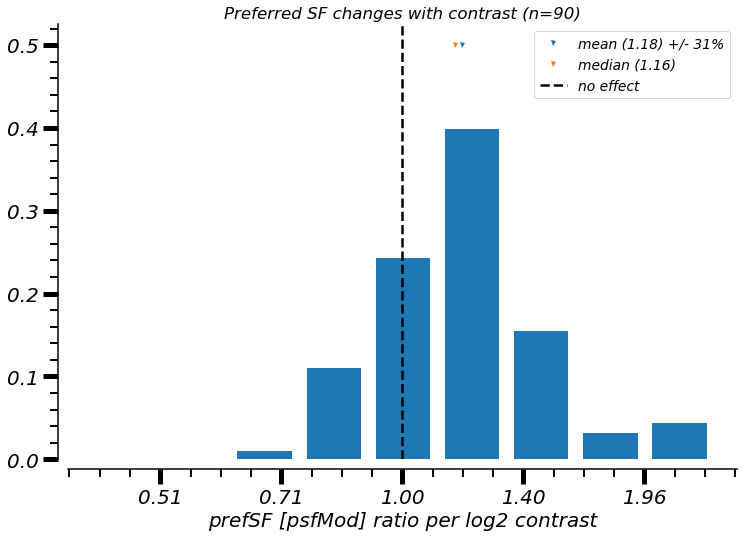

In [1508]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfModRats), np.nanmedian(psfModRats)];
std = np.nanstd(psfModRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF [psfMod] ratio per log2 contrast');
plt.title('Preferred SF changes with contrast %s(n=%d)' % (suffix, sum(vals)), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

...aside: suppose want to look at cells where the ratio shift is in the top 25% (i.e. highest):

In [1506]:
# nan_rm = lambda x: x[~np.isnan(x)]

# prctile = 75;
# thresh = np.percentile(nan_rm(psfModRats), prctile)
# # thresh = np.percentile(np.abs(nan_rm(psfRats)), prctile)
# shiftCells = np.where(psfModRats>thresh)[0]

# allChiDiffs = [];

# for i in shiftCells:
#     currEntry = jointList[i];
#     currName = currEntry['metadata']['expName'];
#     try:
#         flat, wght = currEntry['model']['NLL_flat'], currEntry['model']['NLL_wght'];
#         chiSqDiff = flat-wght;
#         allChiDiffs.append(chiSqDiff);
#         print('%s: flat|wght is (%.2f|%.2f)' % (currName, flat, wght));
#     except: # no fit for this cell
#         pass
# allChiDiffs = np.array(allChiDiffs);
    
# sns.distplot(allChiDiffs[~np.isnan(allChiDiffs)], kde=False);
# sns.despine(offset=10);

### sf70 with contrast inferred from descriptive fit to pSf vs. con

Now, we plot the ratio of preferred spatial frequencies in the data set. Here, we are using "pSfModRat" - a derived measure in which we fit a simple polynomial equation to the preferred frequencies as a function of contrast (see descr_fits.py for details).

- In [0, 0], the ratio of preferred spatial frequencies ($\frac{con_a}{con_b}$) evaluated at the extrema contrasts
- In [0, 1], the ratio of preferred spatial frequencies is expressed per unit log2 contrast

In [1511]:
centerBin = 1; # if 1, then the middle bin will be centered at 0
whichFit = 0; # 0 for flexible gauss, 1 for DoG

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

if centerBin == 1:
    bins = np.linspace(-1.25, 1.25, 10);
    binSuffix = '_verAlt'
else: # if 0, then there is a bin on eitiher side of 0
    bins = np.linspace(-1.25, 1.25, 11);
    binSuffix = '';

saveName = '2_sf70_%sratioMod_%s%s.pdf' % (prefix, fitBase, binSuffix)
# [0, 0] for single gratings, ratio
# [0, 1] for single gratings, ratio per unit log2 contrast
psfModRats = [jointList[i]['metrics']['%ssf70ModRat' % prefix][0, 1] for i in jointList.keys()];
    
psfModRats = np.array(psfModRats);

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfModRats, bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

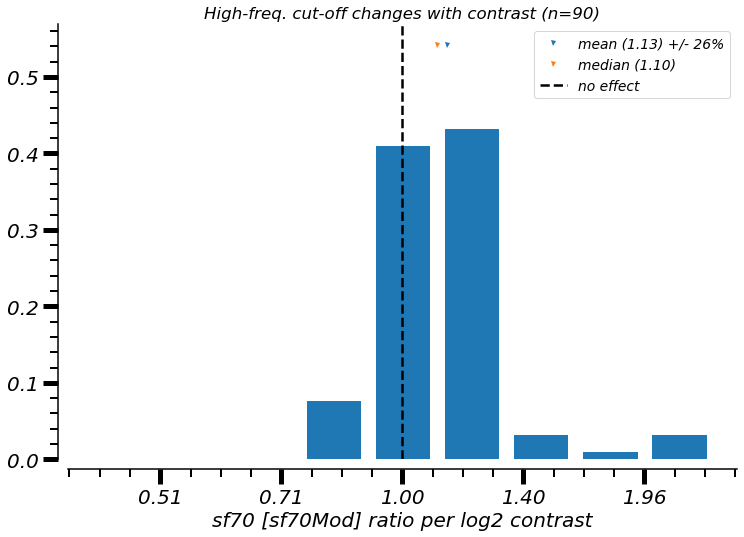

In [1512]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfModRats), np.nanmedian(psfModRats)];
std = np.nanstd(psfModRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('sf70 [sf70Mod] ratio per log2 contrast');
plt.title('High-freq. cut-off changes with contrast %s(n=%d)' % (suffix, sum(vals)), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### Preferred spatial frequency with contrast from data, 1:.33 contrast

In [1515]:
centerBin = 1; # if 1, then the middle bin will be centered at 0
whichFit = 1; # 0 for flexible gauss, 1 for DoG

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

if centerBin == 1:
    bins = np.linspace(-1.25, 1.25, 10);
    binSuffix = '_verAlt'
else: # if 0, then there is a bin on eitiher side of 0
    bins = np.linspace(-1.25, 1.25, 11);
    binSuffix = '';

saveName = '2_sfPref_%sratioFixedCon_%s%s.pdf' % (prefix, fitBase, binSuffix);

# get psfRatio 1:.33 contrast (raw value, not norm. to con value)
disp = 0; # i.e. single gratings
toNorm = 0;
if toNorm == 1:
    conNorm = np.log2(1/0.33);
else:
    conNorm = 1;
    
# why ['diffsAtThirdCon'][2||-1] - [2] is pSf, [-1] is dog_prefSf
whichInd = -1 if whichFit ==  1 else 2
psfRats = [jointList[i]['metrics']['diffsAtThirdCon'][disp, whichInd]/conNorm for i in jointList.keys()];
psfRats = np.array(psfRats);

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


not significant! p=4.74e-01 (n=48)


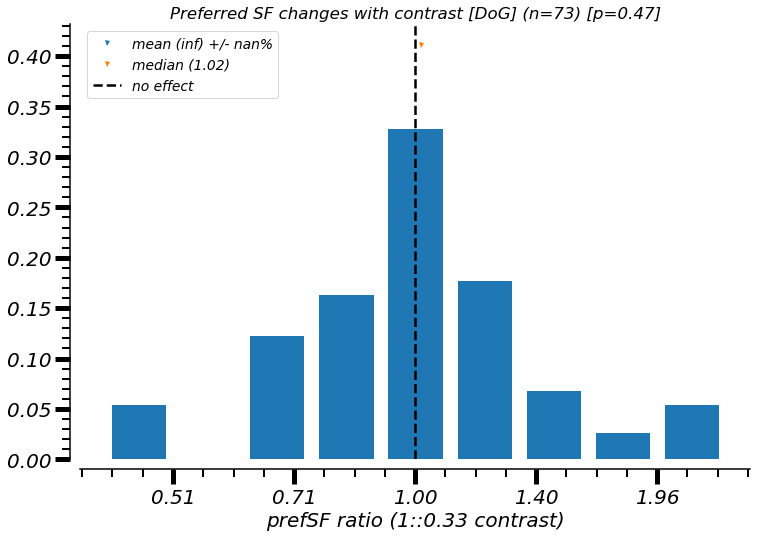

In [1516]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfRats), np.nanmedian(psfRats)];
std = np.nanstd(psfRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small', loc='upper left');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF ratio (1::0.33 contrast)');

# -- compute p value
highCon = hf.jl_get_metric_byCon(jointList, '%spSf' % prefix,  conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, '%spSf' % prefix, conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));
paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('not significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
# -- end compute p val

plt.title('Preferred SF changes with contrast %s(n=%d) [p=%.2f]' % (suffix, sum(vals), pval), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

## Scatter plots!
#### *As of 21.05.05, we will also plot histograms of ratios/differences for some of the scatter plots*

### 0a. Model - variance explained

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


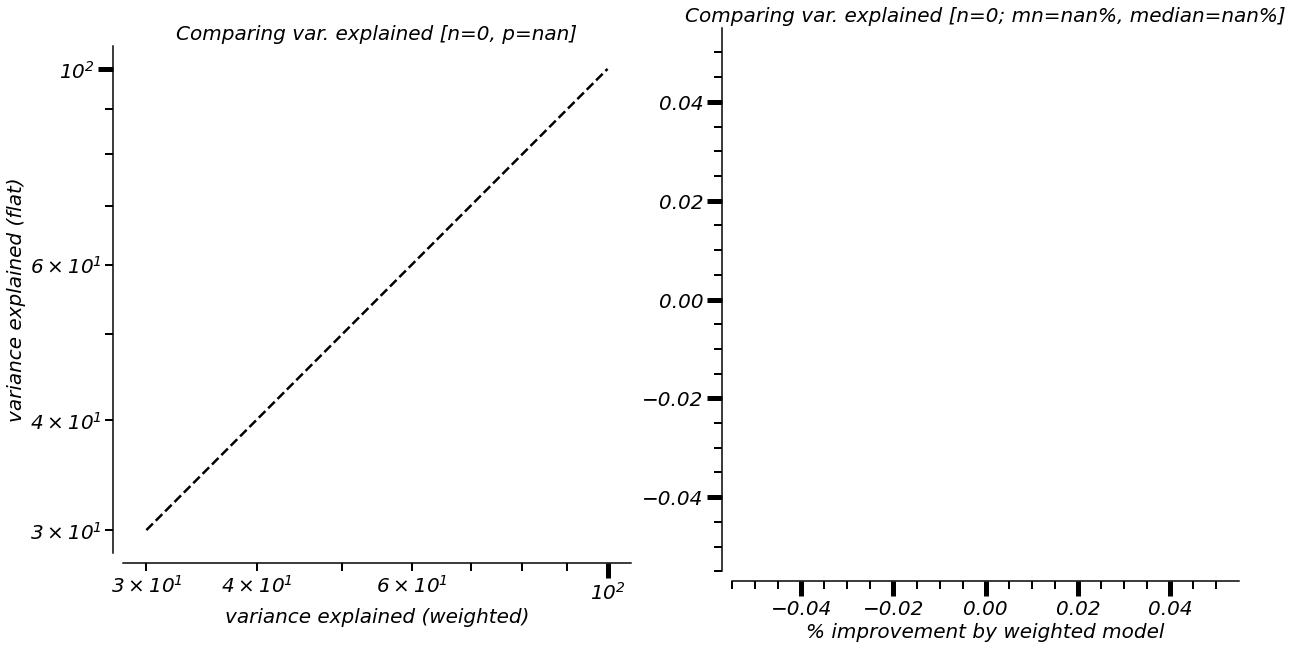

In [1517]:
saveName = '2_varExpl_%s.pdf' % (fitBaseMod);

nrow, ncol = 1, 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10,nrow*10))

flatVE = np.array([jointList[x]['model']['varExplF'] if 'varExplF' in jointList[x]['model'] else np.nan for x in jointList.keys()])
wghtVE = np.array([jointList[x]['model']['varExplW'] if 'varExplW' in jointList[x]['model'] else np.nan for x in jointList.keys()])

flatRemove = np.where([x is None for x in flatVE])[0]
wghtRemove = np.where([x is None for x in wghtVE])[0]
noNone = np.setdiff1d(np.arange(len(flatVE)), np.union1d(flatRemove, wghtRemove))

flatVE = flatVE[noNone]
wghtVE = wghtVE[noNone]

# only take fits where both varExpl are above 0!
# flatOk = [x if val>0 else -1 for x,val in enumerate(flatVE)]
whichOk = np.where(np.logical_and(flatVE>30, wghtVE>30))[0]

flatOk = np.array(flatVE[whichOk], dtype=float)
wghtOk = np.array(wghtVE[whichOk], dtype=float)

### First as scatter
ax[0].scatter(wghtOk, flatOk, color='k');
ax[0].loglog([3e1, 1e2], [3e1, 1e2], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('variance explained (weighted)')
ax[0].set_ylabel('variance explained (flat)')
paired_t = ss.ttest_rel(wghtOk, flatOk)
pval = paired_t.pvalue;

ax[0].set_title('Comparing var. explained [n=%d, p=%.2e]' % (len(whichOk), pval))

### Then as histogram of relative varExpl reduction
fracVals = 100*(wghtOk-flatOk)/flatOk;
bins = np.linspace(-20, 20, 12)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
fracClipped = np.clip(fracVals, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(fracClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
ax[1].set_xlabel('% improvement by weighted model')

ax[1].set_title('Comparing var. explained [n=%d; mn=%.2f%%, median=%.2f%%]' % (len(whichOk), mean, median))

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 0b. Variance explained, but only single gratings

In [153]:
np.nanmean(jointList[10]['model']['varExplW_SF'][0,:])

62.08061426812455

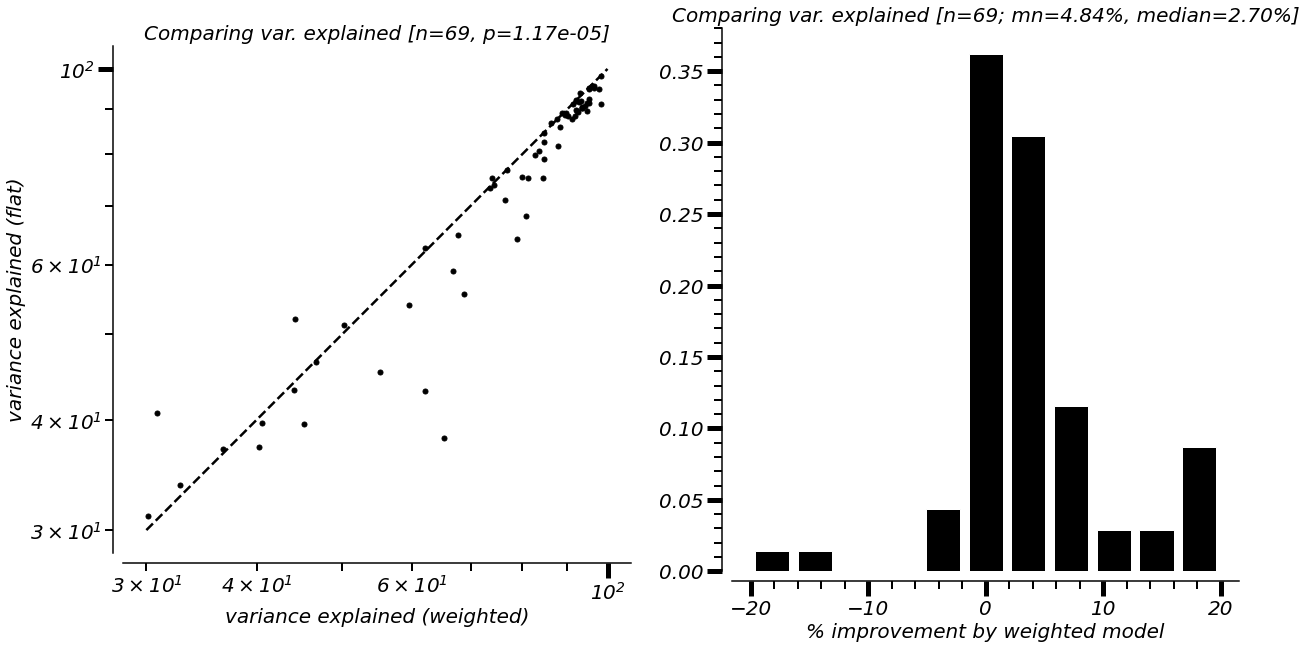

In [160]:
saveName = '2_varExpl_singleGrats_%s.pdf' % (fitBaseMod);

nrow, ncol = 1, 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10,nrow*10))

flatVE = np.array([np.nanmean(jointList[x]['model']['varExplF_SF'][0,:]) if jointList[x]['model']['varExplF_SF'] is not None else None for x in jointList.keys()])
wghtVE = np.array([np.nanmean(jointList[x]['model']['varExplW_SF'][0,:]) if jointList[x]['model']['varExplW_SF'] is not None else None for x in jointList.keys()])

flatRemove = np.where([x is None for x in flatVE])[0]
wghtRemove = np.where([x is None for x in wghtVE])[0]
noNone = np.setdiff1d(np.arange(len(flatVE)), np.union1d(flatRemove, wghtRemove))

flatVE = flatVE[noNone]
wghtVE = wghtVE[noNone]

# only take fits where both varExpl are above 0!
# flatOk = [x if val>0 else -1 for x,val in enumerate(flatVE)]
whichOk = np.where(np.logical_and(flatVE>30, wghtVE>30))[0]

flatOk = np.array(flatVE[whichOk], dtype=float)
wghtOk = np.array(wghtVE[whichOk], dtype=float)

### First as scatter
ax[0].scatter(wghtOk, flatOk, color='k');
ax[0].loglog([3e1, 1e2], [3e1, 1e2], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('variance explained (weighted)')
ax[0].set_ylabel('variance explained (flat)')
paired_t = ss.ttest_rel(wghtOk, flatOk)
pval = paired_t.pvalue;

ax[0].set_title('Comparing var. explained [n=%d, p=%.2e]' % (len(whichOk), pval))

### Then as histogram of relative varExpl reduction
fracVals = 100*(wghtOk-flatOk)/flatOk;
bins = np.linspace(-20, 20, 12)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
fracClipped = np.clip(fracVals, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(fracClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
ax[1].set_xlabel('% improvement by weighted model')

ax[1].set_title('Comparing var. explained [n=%d; mn=%.2f%%, median=%.2f%%]' % (len(whichOk), mean, median))

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 0c. Only mixtures

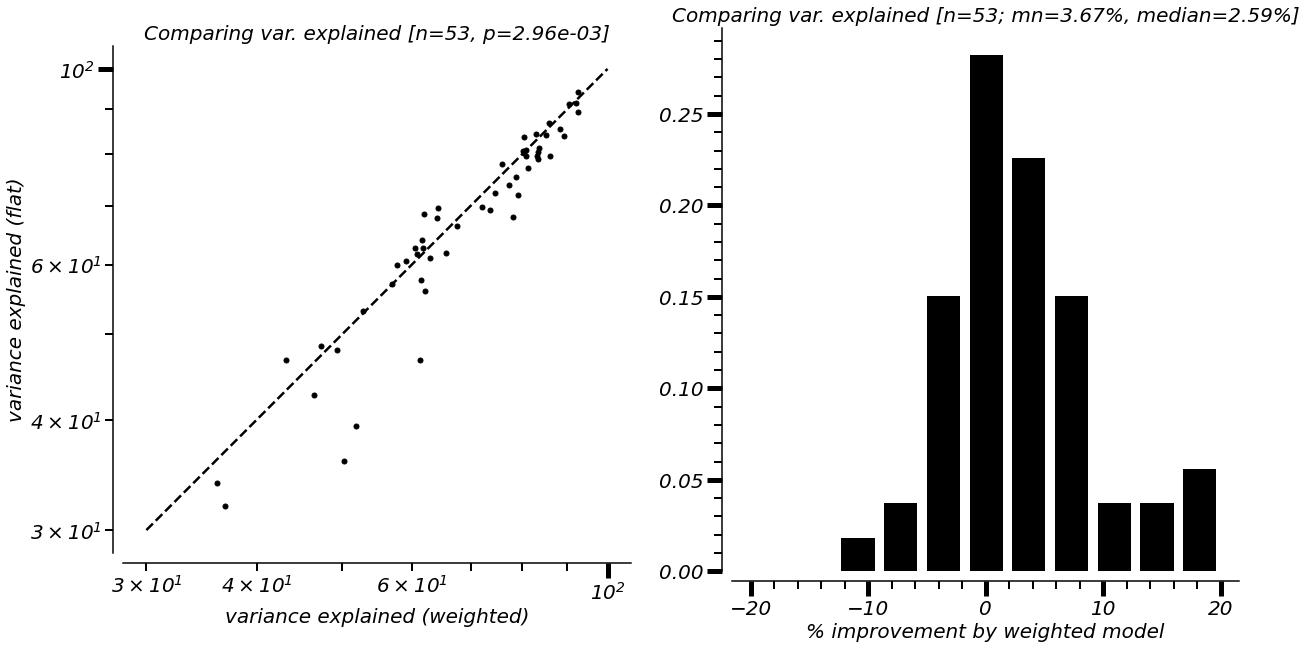

In [163]:
saveName = '2_varExpl_onlyMixtures_%s.pdf' % (fitBaseMod);

nrow, ncol = 1, 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol*10,nrow*10))

flatVE = np.array([np.nanmean(jointList[x]['model']['varExplF_SF'][1:,:]) if jointList[x]['model']['varExplF_SF'] is not None else None for x in jointList.keys()])
wghtVE = np.array([np.nanmean(jointList[x]['model']['varExplW_SF'][1:,:]) if jointList[x]['model']['varExplW_SF'] is not None else None for x in jointList.keys()])

flatRemove = np.where([x is None for x in flatVE])[0]
wghtRemove = np.where([x is None for x in wghtVE])[0]
noNone = np.setdiff1d(np.arange(len(flatVE)), np.union1d(flatRemove, wghtRemove))

flatVE = flatVE[noNone]
wghtVE = wghtVE[noNone]

# only take fits where both varExpl are above 0!
# flatOk = [x if val>0 else -1 for x,val in enumerate(flatVE)]
whichOk = np.where(np.logical_and(flatVE>30, wghtVE>30))[0]

flatOk = np.array(flatVE[whichOk], dtype=float)
wghtOk = np.array(wghtVE[whichOk], dtype=float)

### First as scatter
ax[0].scatter(wghtOk, flatOk, color='k');
ax[0].loglog([3e1, 1e2], [3e1, 1e2], 'k--')
ax[0].axis('square')
ax[0].set_xlabel('variance explained (weighted)')
ax[0].set_ylabel('variance explained (flat)')
paired_t = ss.ttest_rel(wghtOk, flatOk)
pval = paired_t.pvalue;

ax[0].set_title('Comparing var. explained [n=%d, p=%.2e]' % (len(whichOk), pval))

### Then as histogram of relative varExpl reduction
fracVals = 100*(wghtOk-flatOk)/flatOk;
bins = np.linspace(-20, 20, 12)

stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
fracClipped = np.clip(fracVals, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(fracClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
ax[1].set_xlabel('% improvement by weighted model')

ax[1].set_title('Comparing var. explained [n=%d; mn=%.2f%%, median=%.2f%%]' % (len(whichOk), mean, median))

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1zero. Center of mass with contrast from data (1:.33 contrast and 1:lowestValid contrast)

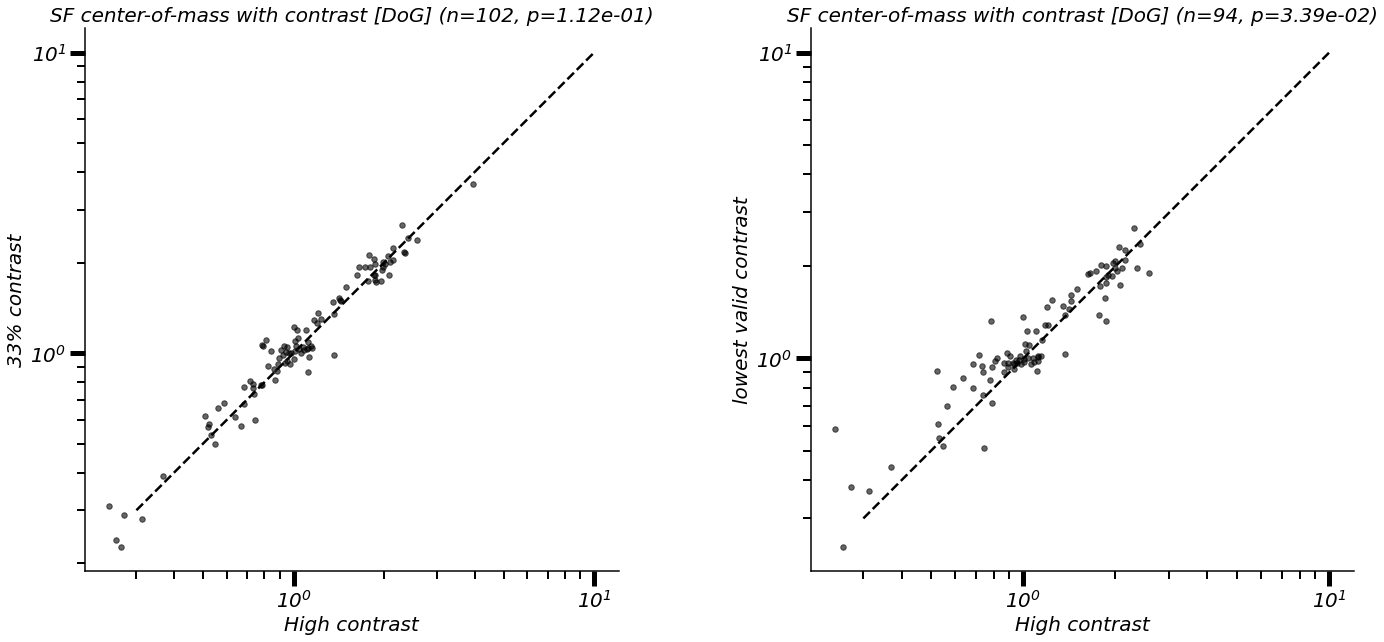

In [1520]:
excludeOneThirds = 0
exclStr = '_excl33' if excludeOneThirds else ''

saveName = '2_sfPref_COM_scatter_%s%s.pdf' % (fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

rats_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    
    highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'sfCom', 0, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0]; # must be less than 30% to be included...
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)

    rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('SF center-of-mass with contrast %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


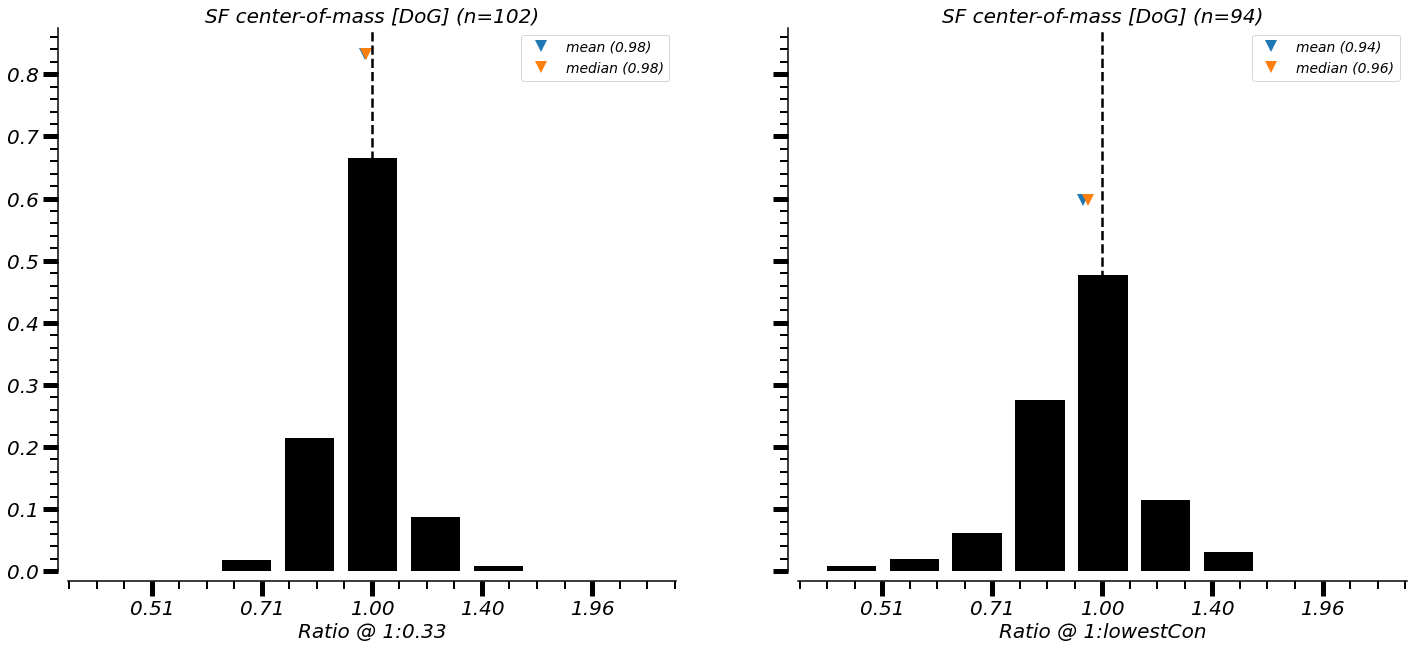

In [1521]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('SF center-of-mass %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1. Preferred spatial frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

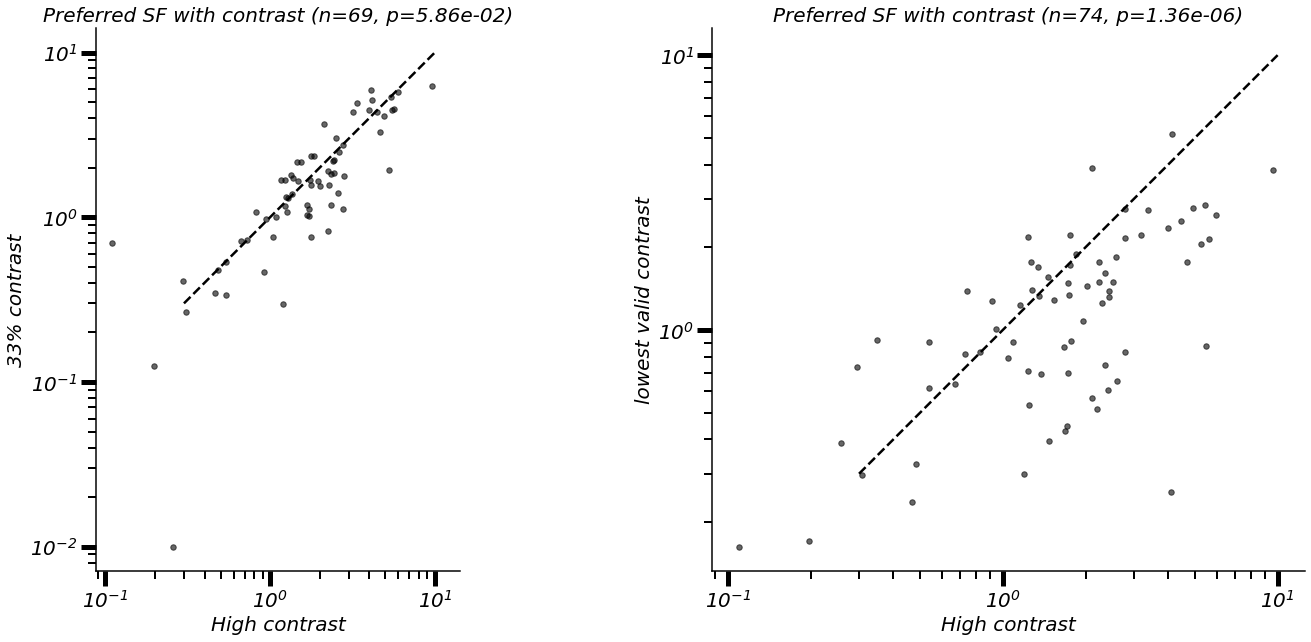

In [1524]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

saveName = '2_sfPref_%sscatter_%s%s.pdf' % (prefix, fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

rats_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):

    highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%spSf' % prefix, whichFit, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
       
    rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
        
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Preferred SF with contrast %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


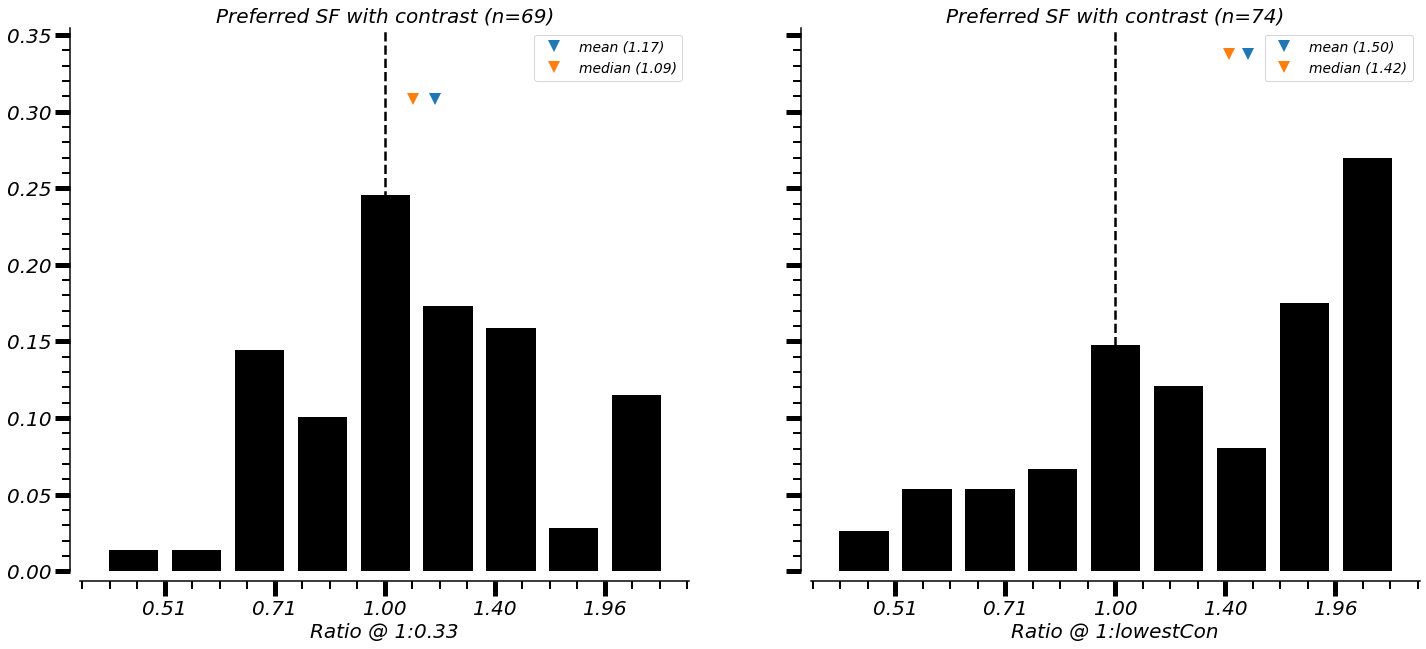

In [1525]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    mean, median = [np.nanmean(fracVals), np.nanmedian(fracVals)];
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('Preferred SF with contrast %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1b. sf70 with contrast from data (1:.33 contrast and 1:lowestValid contrast)

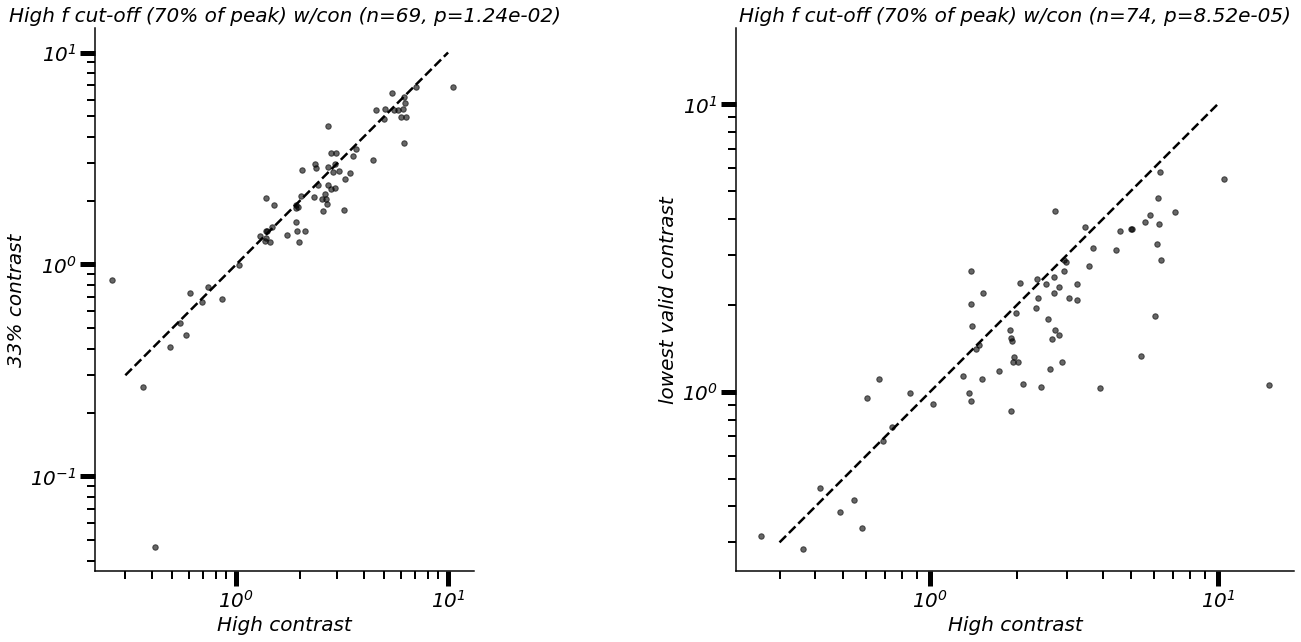

In [1528]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

saveName = '2_sf70_%sscatter_%s%s.pdf' % (prefix, fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

rats_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    
    highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, '%ssf70' % prefix, whichFit, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
    
    rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('High f cut-off (70%% of peak) w/con %s(n=%d, p=%.2e)' % (suffix, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


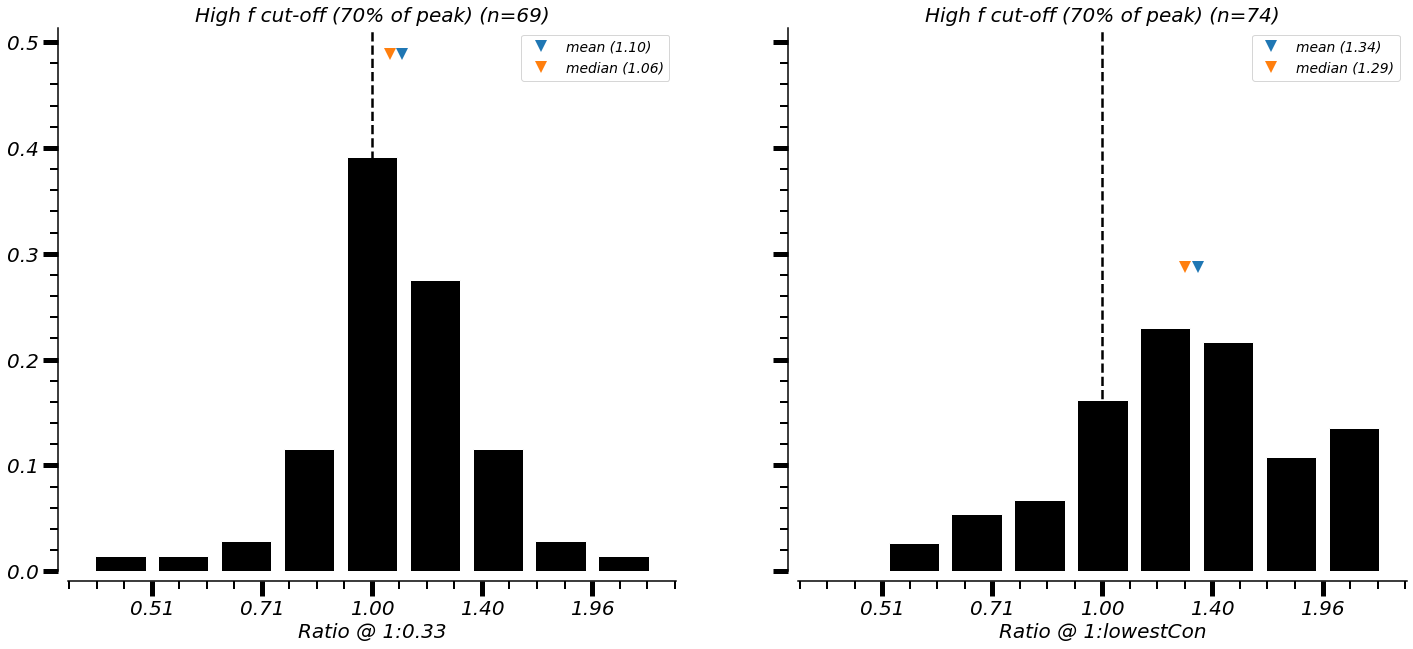

In [1529]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    mean, median = [np.nanmean(rats), np.nanmedian(rats)];
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('High f cut-off (70%% of peak) %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 1c. Characteristic frequency with contrast from data (1:.33 contrast and 1:lowestValid contrast)

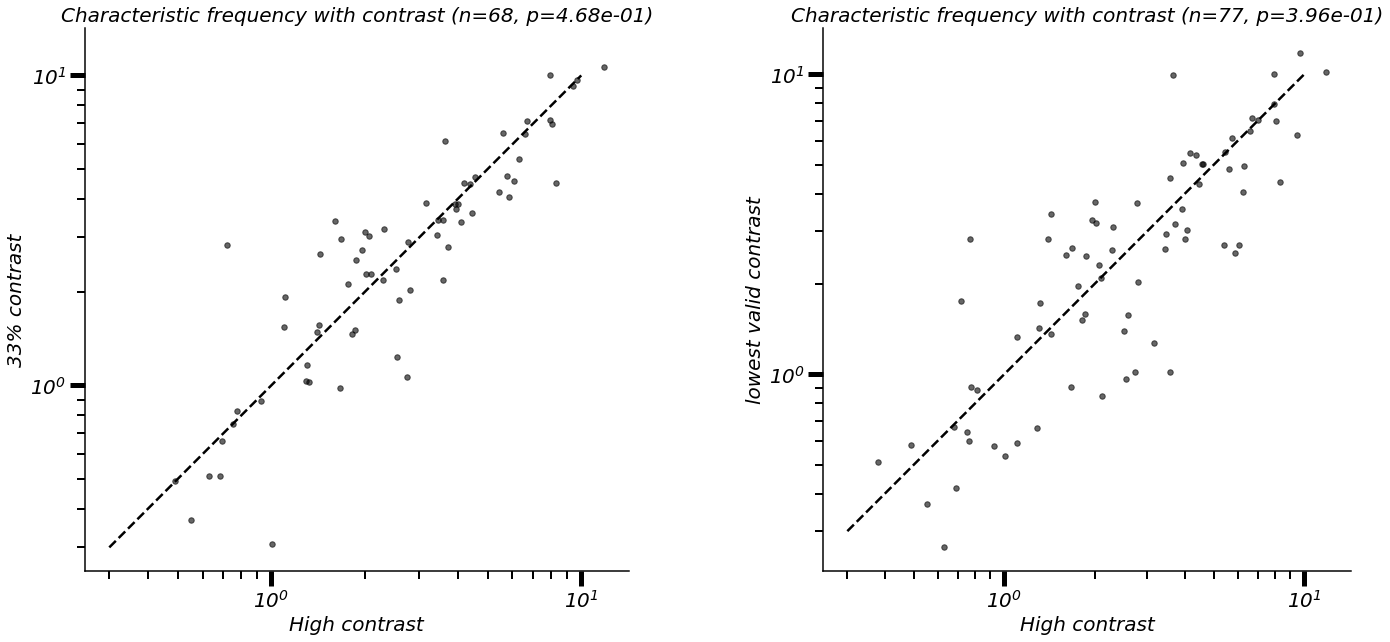

In [1530]:
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''

saveName = '2_sfCharFreq_scatter_%s%s.pdf' % (fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

rats_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):

    highSf, compSf, compCons = hf.jl_get_metric_highComp(jointList, 'dog_charFreq', 1, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highSf), ~np.isnan(compSf))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
    
    rats_both.append(np.divide(highSf[val_inds], compSf[val_inds]))
    
    ax[i].scatter(highSf[val_inds], compSf[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([0.3,10], [0.3, 10], 'k--')
    paired_t = ss.ttest_rel(highSf[val_inds], compSf[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Characteristic frequency with contrast (n=%d, p=%.2e)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


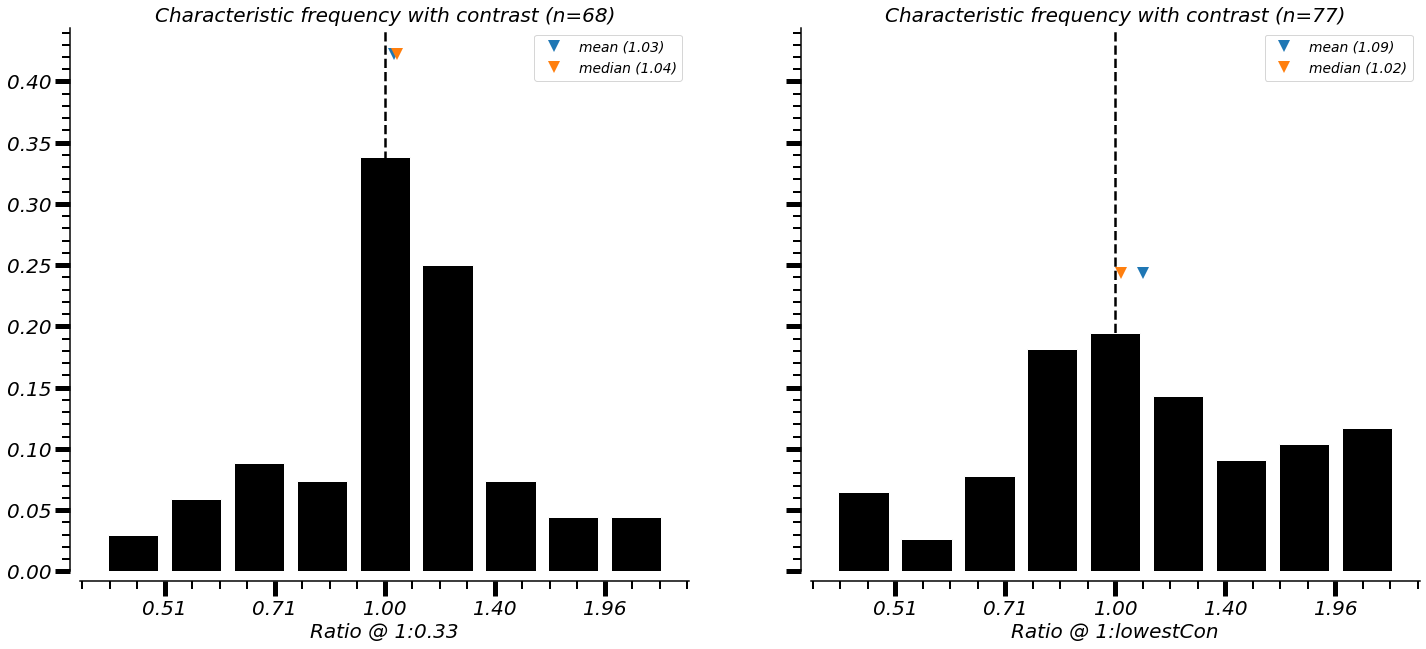

In [1531]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('Characteristic frequency with contrast %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 2. Bandwidth

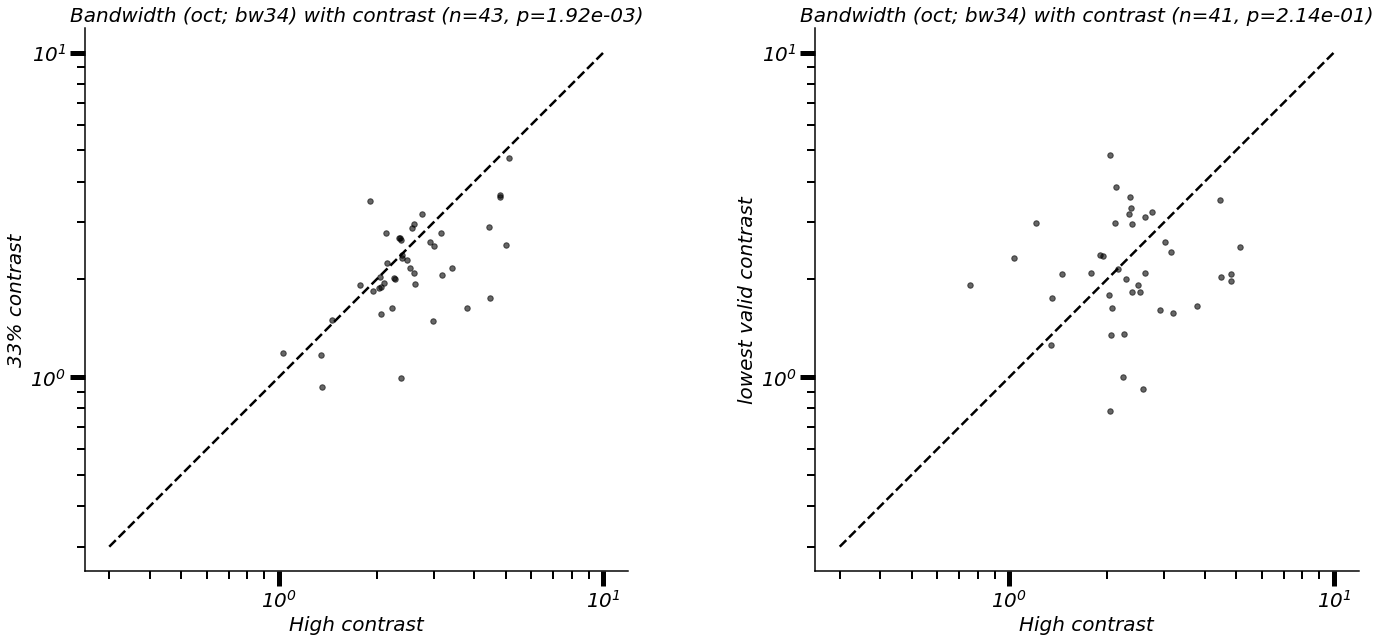

In [1538]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
whichBw = 1; # 0 for half, 1 for 34
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3

prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''

exclStr = '_excl33' if excludeOneThirds else ''
bwStr = 'bwHalf' if whichBw == 0 else 'bw34';
saveName = '2_%s_scatter_%s%s%s.pdf' % (bwStr, prefix, fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

diffs_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    
    highVal, compVal, compCons = hf.jl_get_metric_highComp(jointList, '%s%s' % (prefix, bwStr), whichFit, i)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
    
    diffs_both.append(highVal[val_inds] - compVal[val_inds])
    
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([3e-1, 10], [3e-1, 10], 'k--')
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Bandwidth (oct; %s) with contrast (n=%d, p=%.2e)' % (bwStr, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


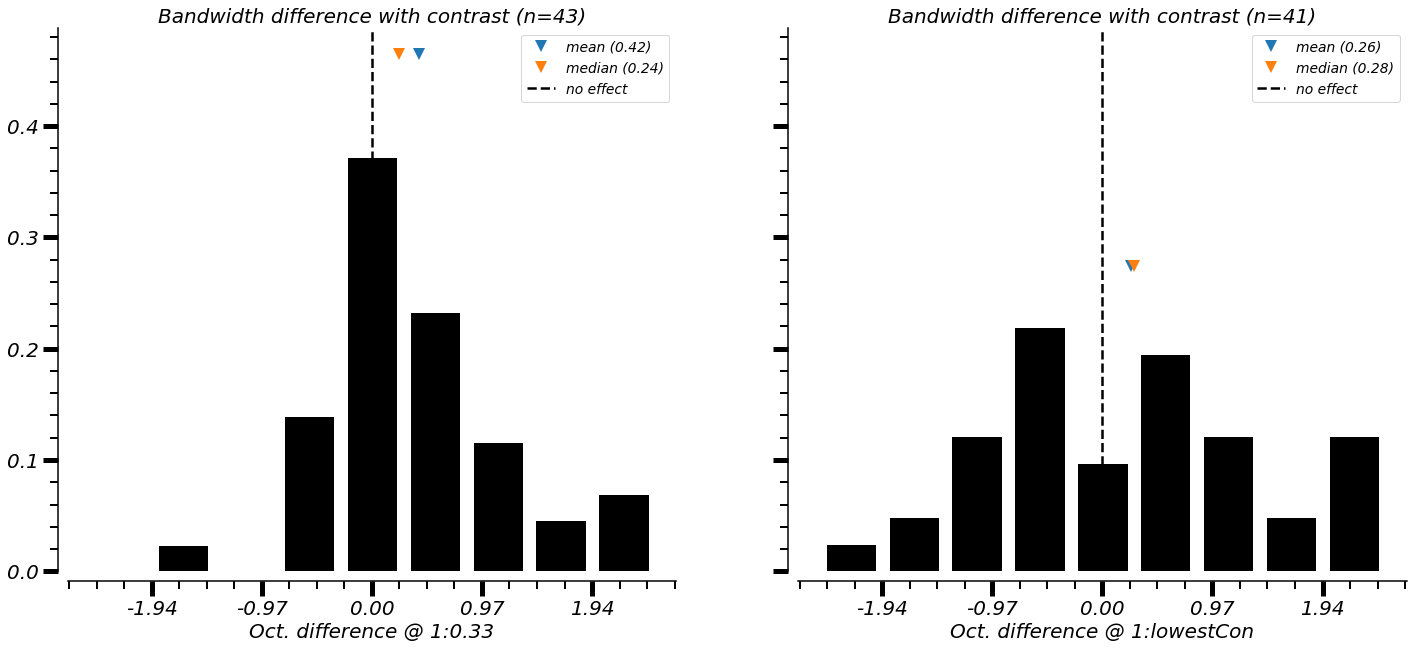

In [1539]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-2.5, 2.5, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, diffs_curr in zip(enumerate(yLabels), xlabs, diffs_both):

    diffs = diffs_curr;
        
    diffsClipped = np.clip(diffs, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(diffsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(diffs), np.nanmedian(diffs);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % mean, markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median, markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % x for x in tickVals]);  
    ax[i].axvline(0, ls='--', c='k', label='no effect')
    ax[i].set_xlabel('Oct. difference @ %s' % xlab)
    ax[i].set_title('Bandwidth difference with contrast %s(n=%d)' % (suffix, len(diffs)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 3. Bandwidth - only one half

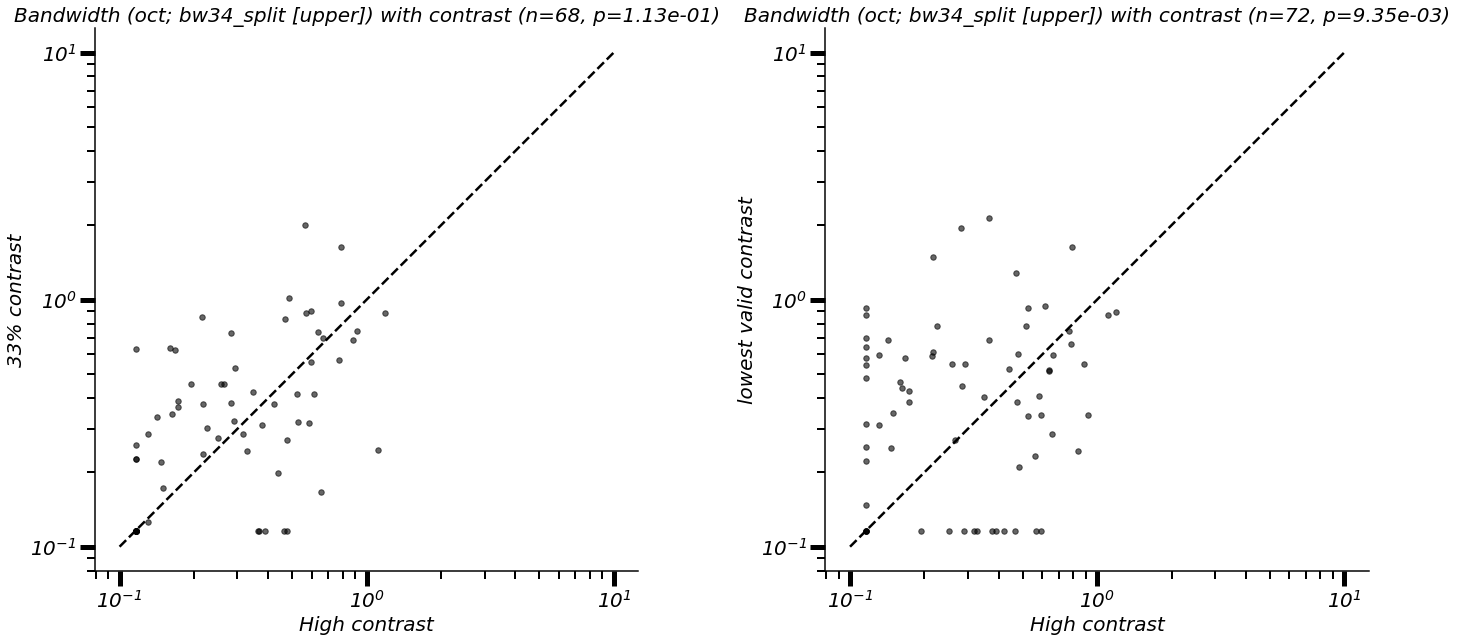

In [1546]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
whichBw = 1; # 0 for half, 1 for 3/4th-height
whichHalf = 1 # 0 is lower, 1 is upper

exclStr = '_excl33' if excludeOneThirds else ''
prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''
bwStr = 'bwHalf_split' if whichBw == 0 else 'bw34_split';
halfLabel = 'lower' if whichHalf == 0 else 'upper'
saveName = '2_%s_%s_scatter_%s%s%s.pdf' % (bwStr, halfLabel, prefix, fitBase, exclStr);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

diffs_both = [];

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):

    highVal, compVal, compCons = hf.jl_get_metric_highComp(jointList, '%s%s' % (prefix, bwStr), whichFit, i, extraInds=whichHalf)
    
    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
    
    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
    
    diffs_both.append(highVal[val_inds] - compVal[val_inds])
    
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].loglog([1e-1, 10], [1e-1, 10], 'k--')     
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('Bandwidth (oct; %s [%s]) with contrast (n=%d, p=%.2e)' % (bwStr, halfLabel, len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


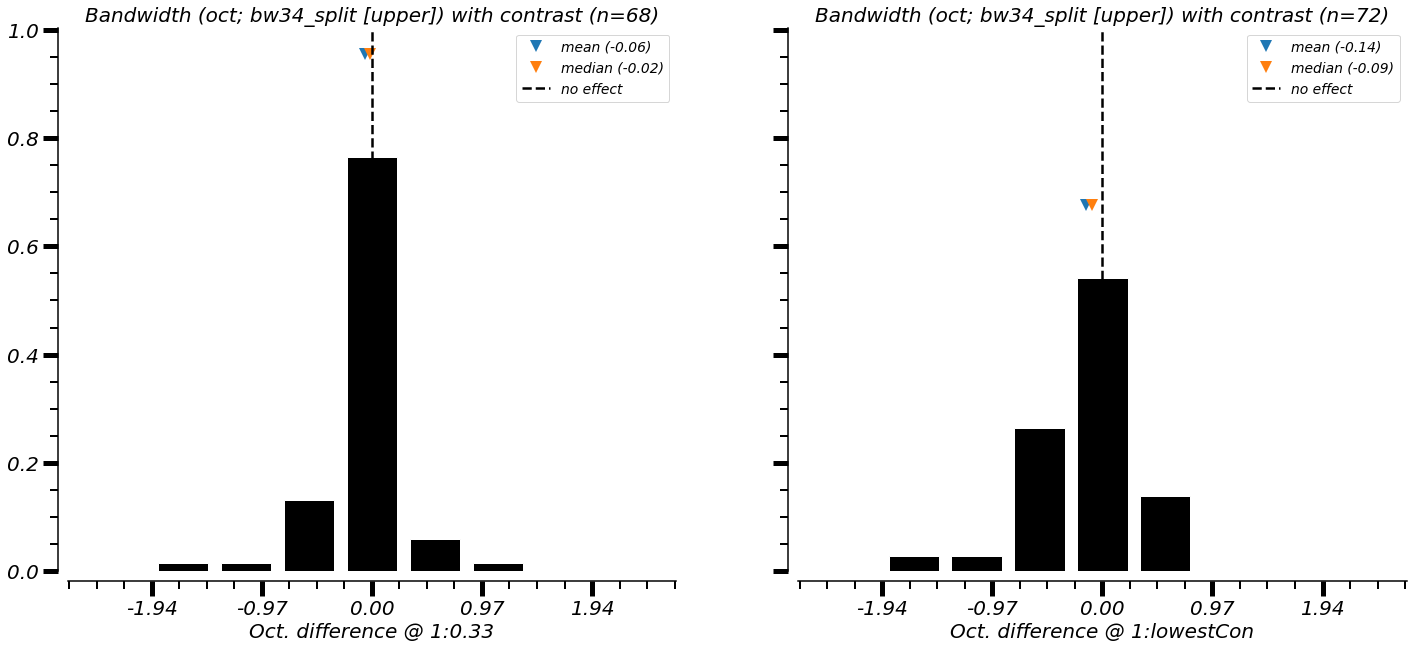

In [1547]:
# Then, the histogram
saveName = saveName.replace('scatter', 'hist')

f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10), sharey=True)

bins = np.linspace(-2.5, 2.5, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, diffs_curr in zip(enumerate(yLabels), xlabs, diffs_both):

    diffs = diffs_curr;
        
    diffsClipped = np.clip(diffs, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(diffsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(diffs), np.nanmedian(diffs);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % mean, markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median, markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');bins = np.linspace(-1.25, 1.25, 10);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
tickVals = np.linspace(bins[1], bins[-2], 5);

xlabs = ['1:0.33', '1:lowestCon']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for (i,ylbl), xlab, rats_curr in zip(enumerate(yLabels), xlabs, rats_both):

    rats = np.log2(rats_curr);
        
    ratsClipped = np.clip(rats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)
    vals, _ = np.histogram(ratsClipped, bins=bins)
    vals_norm = vals/np.sum(vals)
       
    mean, median = np.nanmean(rats), np.nanmedian(rats);
        
    ax[i].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f)' % np.power(2, mean), markersize=12);
    ax[i].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median), markersize=12);
        
    ax[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);  
    ax[i].axvline(0, color='k', linestyle='--')
    ax[i].set_xlabel('Ratio @ %s' % xlab)
    ax[i].set_title('High f cut-off (70%% of peak) %s(n=%d)' % (suffix, len(rats)))
    ax[i].legend(fontsize='x-small')
    ax[i].set_xticks(tickVals)
    ax[i].set_xticklabels(['%.2f' % x for x in tickVals]);  
    ax[i].axvline(0, ls='--', c='k', label='no effect')
    ax[i].set_xlabel('Oct. difference @ %s' % xlab)
    ax[i].set_title('Bandwidth (oct; %s [%s]) with contrast %s(n=%d)' % (bwStr, halfLabel, suffix, len(diffs)))
    ax[i].legend(fontsize='x-small')

sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


### 4. Bandwidth - by halves, showing relative change in each half

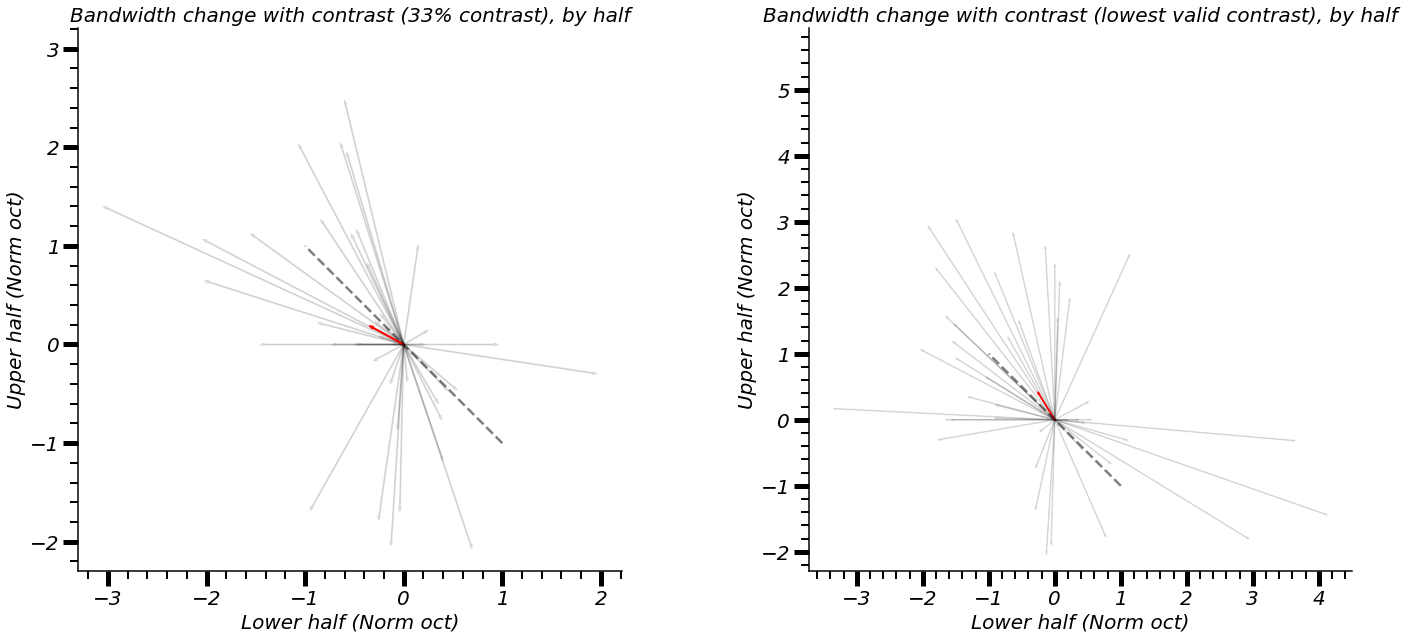

In [1551]:
whichFit = 0; # 0 for flexible gauss, 1 for DoG
whichBw = 1;
fromOrigin = 1; # if 0, we just show the vec from hi to comp con; if 1, we center all vectors at origin
normOct = 1; # normalize lower/upper half to the oct bandwidth at high contrast
unitVecs = 0; # if unit vectors, every change will have length of 1

arrowWidth = 0.01
prefix = 'dog_' if whichFit==1 else ''
suffix = '[DoG] ' if whichFit==1 else ''
bwStr = 'bwHalf_split' if whichBw == 0 else 'bw34_split';
originStr = '' if fromOrigin == 0 else 'Origin'
normStr = 'Norm' if normOct else '';
unitStr = 'UnitVec' if unitVecs else '';

saveName = '2_%s_traj%s%s%s_%s%s.pdf' % (bwStr, originStr, normStr, unitStr, prefix, fitBase);

nrow, ncol = 1,2
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):

#     highInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,0] for x in jointList.keys()]);
#     # compInd will first be at one third (when i==0), then at lowest valid contrast...
#     compInd = np.array([jointList[x]['metrics']['relDescr_inds'][disp,i+1] for x in jointList.keys()]);
    
#     highVecOrig = np.array([jointList[key]['metrics']['%s%s' % (prefix, bwStr)][disp, hI, :] for key,hI in zip(jointList.keys(), highInd)])
#     compVecOrig = np.array([jointList[key]['metrics']['%s%s' % (prefix, bwStr)][disp, cI, :] for key,cI in zip(jointList.keys(), compInd)])

    highVecOrig, compVecOrig, compCons = hf.jl_get_metric_highComp(jointList, '%s%s' % (prefix, bwStr), whichFit, i)

    if normOct:
        highVec = np.divide(highVecOrig, highVecOrig)
        compVec = np.divide(compVecOrig, highVecOrig)
    else:
        highVec = highVecOrig
        compVec = compVecOrig
    if normOct:
        vecChange = np.log2(compVec)
    else:
        vecChange = -highVec+compVec
    if unitVecs:
        vecChange = np.array([curr / np.linalg.norm(curr) for curr in vecChange])
    
    if fromOrigin:
        [ax[i].arrow(0,0,*vecCh, width=arrowWidth, color='k', alpha=0.1) for vecCh in vecChange]
        ax[i].plot([1,-1],[-1,1], 'k--', alpha=0.5)
        meanChange = np.nanmean(vecChange, axis=0);
        ax[i].arrow(0,0,*meanChange, width=arrowWidth, color='r', alpha=1)
    else:
        [ax[i].arrow(*high,*vecCh, width=arrowWidth, color='k', alpha=0.1) for high,vecCh in zip(highVec, vecChange)]
    ax[i].set_xlabel('Lower half (%s oct)' % normStr)
    ax[i].set_ylabel('Upper half (%s oct)' % normStr)
    ax[i].set_title('Bandwidth change with contrast %s(%s), by half' % (suffix, ylbl))
#     ax[i].set_xlabel('High contrast')
#     ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 5. LSFV (per Xing et al, 2004)

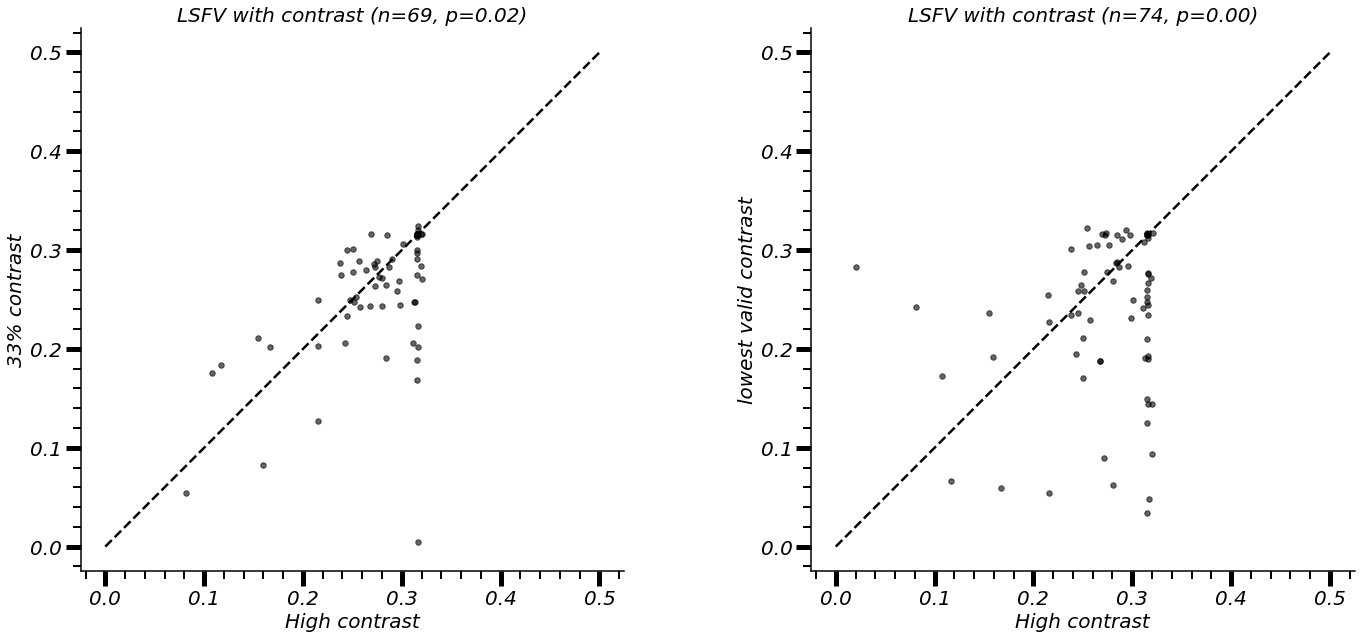

In [1552]:
excludeOneThirds = 0; # if 1, then we don't count include cells which have a lowest valid contrast GTE to 1/3
exclStr = '_excl33' if excludeOneThirds else ''

saveName = '2_LSFV_ConScatter_%s%s.pdf' % (fitBase, exclStr);

nrow, ncol = 1,2 
f, ax = plt.subplots(nrow,ncol, figsize=(ncol*12, nrow*10))

disp=0
yLabels = ['33% contrast', 'lowest valid contrast']

# first one will be 1:.33 (i.e. raw values); second will be 1:lowest
for i,ylbl in enumerate(yLabels):
    # we only compute LSFV for flex. gauss fits, as of 21.05.05
    highVal, compVal, compCons = hf.jl_get_metric_highComp(jointList, 'lsfv', 0, i)

    if excludeOneThirds and i == 1:
        validInds = np.where(compCons<0.3)[0];
    else:
        validInds = np.where(compCons<0.4)[0]; # obviously, we exclude lowest cons which are the same!
        
    non_nan = np.logical_and(~np.isnan(highVal), ~np.isnan(compVal))
    val_inds = np.intersect1d(np.where(non_nan)[0], validInds)
        
    ax[i].scatter(highVal[val_inds], compVal[val_inds], alpha=0.6, color='k', s=30)
    ax[i].plot([0, 0.5], [0, 0.5], 'k--')
    paired_t = ss.ttest_rel(highVal[val_inds], compVal[val_inds])
    pval = paired_t.pvalue;
    ax[i].set_title('LSFV with contrast (n=%d, p=%.2f)' % (len(val_inds), pval))
    ax[i].set_xlabel('High contrast')
    ax[i].set_ylabel(ylbl)
    ax[i].axis('square')

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

### 4. Show the trajectory of these measures across all contrasts
Rather than simply analyzing the ratio at any two contrasts, let's consider the evolution of these measures across all contrasts (for a given cell and dispersion)

In [419]:
#######
# First, decide which measure we're using; prepare plot
#######
subset = ['all', 'V1orig', 'V1new']

sfMetrics = ['sfCom', 'pSf', 'bwHalf'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']

# allCon_sf  = dict();
# allCon_con = dict();

nCells = len(jointList);

maxCons = np.max([len(jointList[i]['metadata']['stimVals'][1]) for i in jointList.keys()]); # max nCons
# dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));

for mtr, mtrClr in zip(sfMetrics, metricColor):

    for sub_ind, sbst in zip(range(len(subset)), subset):
    
        saveName = 'sfTune_conTrends_%s_%s.pdf' % (mtr, sbst)

        #######
        # subset the data
        #######
        
        # first, determine which cells we'll consider
        expInds = np.array([jointList[i]['metadata']['expInd'] for i in jointList.keys()])
        if sub_ind == 0: # all data
            # NOTE: yes, we could just grab 'median', but want to track # cells
            ok = np.where(expInds > 0)[0]; # i.e. any experiment...
        elif sub_ind == 1: # V1_orig
            ok = np.where(expInds == 1)[0]
        elif sub_ind == 2: # V1
            ok = np.where(expInds != 1)[0]
    
        # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
        # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)

        #######
        # set up plot, analyses
        #######
        maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in ok]) # 0 for disps...
        dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));
        f, ax = plt.subplots(maxDisp, 2, figsize=(2*20, nMetrics*20));

        full_slope = [];
        prev_ahh = None; # store previous median slope value

    #     allDisp_sf[con_ind] = dict();
    
        for d, clr in zip(range(maxDisp), dispColor):

            all_sfs = [];
            all_cons = [];
            all_slopes = [];

            for i in ok:

                #######
                # get structure, metadata, etc
                #######
                curr_cell = jointList[i]
                curr_metr = curr_cell['metrics']['%s' % mtr];
                curr_meta = curr_cell['metadata'];
                curr_cons = curr_meta['stimVals'][1];
                curr_byDisp = curr_meta['val_con_by_disp'];
                if d < len(curr_byDisp):
                    curr_inds = curr_byDisp[d];
                else:
                    continue; # i.e. this dispersion isn't ther

                curr_conVals = np.array(curr_cons[curr_inds]);
                curr_metrVal = np.array(curr_metr[d, curr_inds]);

                #######
                # slope measure
                # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
                #######
                non_nan = ~np.isnan(curr_metrVal);
                if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                    curr_slope = np.nan
                else:
                    curr_slope = linregress(np.log2(curr_conVals[non_nan]), curr_metrVal[non_nan])[0];

                all_sfs.append(curr_metrVal);
                all_cons.append(curr_conVals);
                all_slopes.append(curr_slope);

                #######
                # now plot!
                #######

                ax[d, 0].semilogx(curr_conVals, curr_metrVal, linestyle='--', alpha=0.3, color=clr);
                ax[d, 0].set_title('metric: %s' % mtr)

            #######
            # gather for everything, plot
            #######
#             if np.array_equal(all_cons, []):
#                 continue; # what does this mean? When we subset the data, not all dispersions are
            full_slope.append(np.array(all_slopes));

            # now take median, save
            stacked_cons = np.hstack([x for x in all_cons]);
            unique_cons = np.unique(stacked_cons);
            mdn = [];
            for c_lvl in unique_cons:
                ind_byCell = [np.where(x==c_lvl)[0] for x in all_cons]
                sf_byCell = np.array([x[i] for x, i in zip(all_sfs, ind_byCell)]);
                valids = np.hstack([x for x in sf_byCell]);
                mdn.append(np.nanmedian(valids));

            # then plot the median!
            ax[d, 0].semilogx(unique_cons, mdn, '-', linewidth=4, color=clr);

    #         clean up plot
            sns.despine(offset=10);
            ax[d, 0].set_xlabel('contrast');
            ax[d, 0].set_ylabel('%s' % mtr);


            #######
            # now plot hist of slopes
            #######
            cleaned = np.clip(hf.nan_rm(np.array(all_slopes)), -2, 2);
            ax[d, 1].hist(cleaned, color=clr);
            ahh = np.nanmedian(all_slopes);
            ax[d, 1].plot(ahh, -1, 'v', color=clr, markersize=10, label='mdn: (%.2f) (disp: %s)' % (ahh, d+1))
            if prev_ahh is not None:
                ax[d, 1].plot(prev_ahh, -1, 'v', color=prev_clr, markersize=10)
            ax[d, 1].set_xlabel('slope value')
            ax[d, 1].set_ylabel('# cells')
            ax[d, 1].legend();
            ax[d, 1].set_title('slope of metric vs. contrast')
            prev_ahh = ahh;
            prev_clr = clr;

        f.suptitle('tuning measure vs. contrast across dispersion %s' % sbst);

    #######
    # save
    #######

#     if not os.path.exists(save_loc):
#         os.makedirs(save_loc)
#     pdfSv = pltSave.PdfPages(save_loc + saveName);
#     pdfSv.savefig(f) # only one figure here...
#     pdfSv.close()


KeyError: 15

## Preferred spatial frequency with contrast *and* dispersion

Before we ask "how correlated are the frequency shifts at different dispersion levels", let's first consider the central/preferred frequency as a function of dispersion alone, i.e. start with the constituent parts of the ratios.

### Histograms/trajectories of metrics with dispersion, split by contrast

In [ ]:
#######
# First, decide which measure we're using; prepare plot
#######
sfMetrics = ['sfCom', 'pSf', 'sfComCut'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']
con_tol = 0.02;
slope_clip = [-2, 2]; # we're clipping the slope measure for better visualization; see "slope" below


con_lvls = [0.33, 0.47, 0.68, 1.00];

allCon_sf  = dict();
allCon_con = dict();

for con_ind in range(len(con_lvls)):

    con_lvl = con_lvls[con_ind];
    saveName = 'sf_disp_con%03d.pdf' % (100*con_lvl)

    # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
    # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)


    #######
    # set up plot, analyses
    #######
    f, ax = plt.subplots(nMetrics, 2, figsize=(2*20, nMetrics*20));

    full_slope = [];

    allCon_sf[con_ind] = dict();
    allCon_con[con_ind] = dict();
    
    for sfM, ind, clr in zip(sfMetrics, range(nMetrics), metricColor):

        all_sfs = [];
        all_cons = [];
        all_slopes = [];

        for i in jointList.keys():

            #######
            # get structure, metadata, etc
            #######
            curr_cell = jointList[i]
            curr_sfs = curr_cell['metrics']['%s' % sfM];
            curr_meta = curr_cell['metadata'];
            curr_disps = curr_meta['stimVals'][0];
            curr_cons = curr_meta['stimVals'][1];
            curr_byDisp = curr_meta['val_con_by_disp'];

            curr_metric = []; # psf or c.o.m.
            curr_con    = []; # what's the contrast?

            n_disp = len(curr_disps)

            for d in range(n_disp):

                #######
                # get contrast, metric
                #######
                val_cons = curr_cons[curr_byDisp[d]];
                try:
                    # if there's no match, then we'll go to the except
                    match_ind = np.where(np.abs(val_cons-con_lvl)<=con_tol)[0][0];
                    full_con_ind = curr_byDisp[d][match_ind];
                    sf, con = curr_sfs[d][full_con_ind], val_cons[match_ind];
                except: # if there isn't a match
                    sf, con = np.nan, np.nan

                curr_con.append(con)
                curr_metric.append(sf);          

            #######
            # slope measure
            # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
            #######
            non_nan = ~np.isnan(curr_metric);
            if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                curr_slope = np.nan
            else:
                curr_slope = linregress(np.arange(n_disp)[non_nan], np.array(curr_metric)[non_nan])[0];

            all_sfs.append(curr_metric);
            all_cons.append(curr_con);
            all_slopes.append(curr_slope);

            #######
            # now plot!
            #######

            n_disps = len(curr_metric);
            xvals = 1+np.arange(n_disps);
            ax[ind, 0].semilogy(xvals, curr_metric, '-', color=clr, alpha=0.6);
            ax[ind, 0].set_title('metric: %s' % sfM)

        #######
        # gather for everything, plot
        #######
        full_slope.append(np.array(all_slopes));

        # now take average, save
        max_disp = np.max([len(x) for x in all_sfs])
        mdn = [];
        for d in range(max_disp):
            mdn.append(np.nanmedian([asf[d] if len(asf) > d else np.nan for asf in all_sfs]))

        allCon_sf[con_ind][sfM] = dict();
        allCon_sf[con_ind][sfM]['full'] = all_sfs;
        allCon_sf[con_ind][sfM]['median'] = mdn;
        allCon_con[con_ind][sfM] = dict();
        allCon_con[con_ind][sfM] = all_cons;
         
        # then plot!
        ax[ind, 0].semilogy(1+np.arange(max_disp), mdn, 'r-')
        ax[ind, 0].set_xticks(1+np.arange(max_disp))

        # clean up plot
        sns.despine(offset=10);
        ax[ind, 0].set_xlabel('dispersion');
        ax[ind, 0].set_ylabel('%s (c/deg)' % sfM);

        
    #######
    # now plot hist of slopes
    #######
    cleaned = [np.clip(hf.nan_rm(x), -2, 2) for x in full_slope];
    ax[0, 1].hist([x for x in cleaned], stacked=True, label=sfMetrics, color=metricColor);
    # ax[0, 1].hist([hf.nan_rm(np.array(x)) for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    # ahh = [np.median(hf.nan_rm(np.array(x))) for x in full_slope];
    ahh = [np.nanmedian(x) for x in full_slope];
    [ax[0, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[0, 1].set_xlabel('slope value')
    ax[0, 1].set_ylabel('# cells')
    ax[0, 1].legend();
    ax[0, 1].set_title('slope of metric vs. dispersion')

    #######
    # now plot hist of slopes - ONLY for cells with both metrics valid
    #######
    non_nan = np.logical_and(~np.isnan(full_slope[0]), ~np.isnan(full_slope[1]))
    clipped = [np.clip(x[non_nan], -2, 2) for x in full_slope];
    ax[1, 1].hist([x for x in clipped], stacked=True, label=sfMetrics, color=metricColor);
    # ax[1, 1].hist([x[non_nan] for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    ahh = [np.median(x[non_nan]) for x in full_slope];
    [ax[1, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[1, 1].set_xlabel('slope value')
    ax[1, 1].set_ylabel('# cells')
    ax[1, 1].legend();
    ax[1, 1].set_title('matched-only slope of metric vs. dispersion')

    f.suptitle('Center SF vs. dispersion for total contrast %.0f%%' % (100*con_lvl));

    #######
    # save
    #######

    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


### Now plot median by contrast+dispersion

In [ ]:
sfMetricsOrig = sfMetrics
sfMetrics = ['sfCom', 'pSf']

#### sfCOM and preferred SF

In [ ]:
saveName = 'sf_disp_summary.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['full data', 'V1_orig', 'V1 (new)']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in jointList.keys()]);
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInd > 0)[0]; # i.e. any experiment...
            elif nr == 1: # V1_orig
                ok = np.where(expInd == 1)[0]
            elif nr == 2: # V1
                ok = np.where(expInd != 1)[0]
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Comments on dispersion changes

What can we take away from this? As expected, preferred spatial frequency is higher at higher contrasts (_note: this is on average, as here we are not looking at the shifts within cells_); pSF appears to reduce with increasing dispersion (for a fixed contrast). For SF center of mass (c.o.m.), contrast has a minor effect, particularly as viewed for the newest experiments. With increasing dispersion, c.o.m. tends to stay constant (original stimulus) or increase (newer stimuli).

__What do we make of the difference between preferred spatial frequency and center of mass?__ First, let's consider that the set of spatial frequencies is not identical for all dispersions. Specifically, for the new experiment (where the center-of-mass X dispersion interaction is strongest), the extreme spatial frequencies (i.e. lowest/highest) are removed in subsequent dispersion levels. To ensure that the effect above is not caused solely by this stimulus design, let's re-evaluate the c.o.m., but using the same spatial frequencies for all disperesions.

TODO: 

- find examples of interesting or representative C.o.M. versus prefSf cases  
- make "trajectory" plots for _contrast_. That is, show the trend in pSF/COM/BW/Var within cell X dispersion, and across contrast  
- now move on to contrast-shifts across dispersion (i.e. ratio of X for single gratings, Y for dispersion 2, z for dispersion N) -- but not just for the 1:0.33 case, which we already have (see below)  


#### sfCom and sfComCut

As described above, let's compare the c.o.m. metric evaluated over all spatial frequencies to just the set of common sfs which appear in all dispersions

In [ ]:
sfMetrics = ['sfCom', 'sfComCut']

In [ ]:
saveName = 'sf_disp_comCut.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['full data', 'V1_orig', 'V1 (new)']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in jointList.keys()]);
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInd > 0)[0]; # i.e. any experiment...
            elif nr == 1: # V1_orig
                ok = np.where(expInd == 1)[0]
            elif nr == 2: # V1
                ok = np.where(expInd != 1)[0]
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Clearly, the increase in center of mass is not nearly as prominent with only the restricted set of SFs (right). To be fair, the smaller set of SFs provides a metric which will overall be less liable to change. _Nonetheless, it appears that the magnitude - if not existence/sign - of the increased center of mass with increasing contrast is somewhat caused by the stimulus differences between dispersions._ Thus, it would be wise to think carefully about how we can interpret analyses that compare the tuning properties across dispersion, at least for the newer experiments. With the original version of the experiment, we have a consistent set of contrasts and spatial frequency centers. Thus, for those recordings, we can more readily interpret tuning changes across dispersion.

### Contrast shifts across dispersion

How correlated are contrast shifts across dispersion? That is, if a cell has a large pSF reduction with contrast for single gratings, is it there for mixture stimuli, too?

For this, let's look only at the original experiment, since only two dispersions have 33% contrast in the newer stimulus sets. Why is that a problem? Well, we don't want to correlate a tuning shift across only two dispersions, and if we use a higher contrast (e.g. 67, which will appear in more dispersions), then the shifts will be more difficult to see, anyway.

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];

nCells = len(jointList);
slopes, intercepts, r_vals, p_vals, errs = np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, )

In [ ]:
nRow, nCol = len(metrInds), 2;
f, ax  = plt.subplots(nRow, nCol, figsize=(10*nCol, 10*nRow));

for metrInd, mtr, ind in zip(metrInds, metrLabel, range(len(metrInds))):
    for i in jointList.keys():
        if jointList[i]['metadata']['expInd'] != 1: # only considering original experiment
            continue;
        
        metric = np.array(jointList[i]['metrics']['diffsAtThirdCon'][:, metrInd]);
        fullDisp = 1+np.arange(len(metric));
        nonNan = np.where(~np.isnan(metric))[0];
        if not np.array_equal(nonNan, []):
            slopes[i], intercepts[i], r_vals[i], p_vals[i], errs[i] = linregress(fullDisp[nonNan], metric[nonNan]);
#             print('cell %d, r=%.2f (p=%.2f)' % (i+1, r_vals[i], p_vals[i]));

            ax[ind, 0].plot(fullDisp, metric, 'ko-', alpha=0.3)
            ax[ind, 0].set_xlabel('dispersion')
            ax[ind, 0].set_ylabel('log2 ratio')
            # compute significance
            num_nonNan = len(hf.nan_rm(p_vals));
            num_sig = np.sum(hf.nan_rm(p_vals)<0.05)
            ax[ind, 0].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            
    # NOW, plot distribution of correlations across dispersion
    cts = ax[ind, 1].hist(hf.nan_rm(r_vals), color='k')[0];
    medn, abs_medn = np.median(hf.nan_rm(r_vals)), np.median(hf.nan_rm(np.abs(r_vals)));
    ax[ind, 1].set_xlabel('r value');
    ax[ind, 1].set_ylabel('# cells');
    ax[ind, 1].plot(medn, 1.1*np.max(cts), 'kv', label='mdn r (%.2f)' % (medn), markersize=10)
    ax[ind, 1].plot(abs_medn, 1.1*np.max(cts), 'kv', alpha=0.3, label='mdn of abs(r) (%.2f)' % abs_medn, markersize=10)
    ax[ind, 1].set_title('correlation across dispersion')
    ax[ind, 1].legend();
    
sns.despine(offset=5);
f.suptitle('How correlated are contrast shifts across dispersion?');

### Plot shift distributions at each dispersion

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];
metrXlabel = ['log2 sf', 'log2 sf', 'oct bw', 'oct bw', 'a.u.']
metrBins  = [[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5], [-0.5, 0.5], [-0.5, 0.5]]
metrColor = ['r', 'r', 'b', 'b', 'b']

nCells = len(jointList);
maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in jointList.keys()]) # 0 for disps...

In [ ]:
# useful function for getting the metric value in list comprehension: remember that some 
def get_metric(jointList, cell, disp, ind):
    try: 
        return jointList[cell]['metrics']['diffsAtThirdCon'][d, metrInd] 
    except:
        return np.nan


In [ ]:
### ensure X is same within a column

# repeat 3 times - one for all data, one for V1_orig, one for V1 (new)

subset = ['all', 'V1orig', 'V1new']

for i in range(len(subset)):
    
    saveName = 'sfTuning_hist_disp_%s.pdf' % subset[i];
    
    nRow, nCol = maxDisp, len(metrInds);
    f, ax  = plt.subplots(nRow, nCol, figsize=(15*nCol, 15*nRow));

    for metrInd, mtr, mtrX, mtrC, bnds, ind in zip(metrInds, metrLabel, metrXlabel, metrColor, metrBins, range(len(metrInds))):

        mdn_prev = None;

        for d in range(maxDisp):
            # first, determine which cells we'll consider
            expInds = np.array([jointList[i]['metadata']['expInd'] for i in jointList.keys()])
            if i == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInds > 0)[0]; # i.e. any experiment...
            elif i == 1: # V1_orig
                ok = np.where(expInds == 1)[0]
            elif i == 2: # V1
                ok = np.where(expInds != 1)[0]

            # gather the values
            vals = np.array([get_metric(jointList, i, d, metrInd) for i in jointList.keys()]);               
            vals = vals[ok];
            mdn = np.median(hf.nan_rm(vals));
            vals_clipped = np.clip(hf.nan_rm(vals), bnds[0], bnds[1]);
            counts = ax[d, ind].hist(vals_clipped, bins=np.linspace(bnds[0], bnds[1], 811), rwidth=0.8, color=mtrC)[0];
            ax[d, ind].set_xlim(bnds)
            ax[d, ind].axvline(0.0, color='k', linestyle='--')
            ax[d, ind].plot(mdn, 1.1*np.max(counts), 'v', color=mtrC, markersize=10, label='mdn %.2f' % mdn)
            if mdn_prev is not None:
                ax[d, ind].plot(mdn_prev, 1.1*np.max(counts), 'v', color=mtrC, alpha=0.3, markersize=10)
            ax[d, ind].set_title('metric %s, disp %d: (n=%d)' % (mtr, d+1, len(vals_clipped)))
            ax[d, ind].legend();
            # compute significance
#             ax[d, ind].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            ax[d, ind].set_xlabel('%s' % mtrX)
            mdn_prev = mdn;

    sns.despine(offset=10);
    f.suptitle('Differences or ratios in tuning curve metrics [%s]' % subset[i]);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()